In [5]:
import MDAnalysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
file_path = "/home/debian/water/TIP4P/2005/nvt/dump_225_test.lammpstrj"


In [7]:
u = MDAnalysis.Universe(file_path, format="LAMMPSDUMP")

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [8]:
from MDAnalysis.lib.nsgrid import FastNS

观察66号原子的第2000帧的邻居信息，设置截距在3.7埃

In [33]:
target_idx = 69
frame_idx = 2000
cutoff = 3.7  # in Angstroms

In [34]:
u.trajectory[frame_idx]
target_atom = u.atoms[target_idx]
O_atoms = u.select_atoms("type 1")
ns = FastNS(cutoff, O_atoms.positions, u.dimensions)
results = ns.self_search()

In [35]:
pair_indices = results.get_pairs()
print(pair_indices)
# 找到最小的编号和最大的编号
min_idx = np.min(pair_indices)
max_idx = np.max(pair_indices)
print(min_idx, max_idx)

[[ 374  128]
 [ 374 3210]
 [ 374 3101]
 ...
 [2491 3099]
 [1243 2362]
 [1243  237]]
0 4095


In [36]:
print(f"Neighbors of atom {target_idx} at frame {frame_idx} within {cutoff} Å:")
for pair in results.get_pairs():
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        distance = np.linalg.norm(O_atoms.positions[target_idx] - O_atoms.positions[neighbor_idx])
        print(f"Atom {neighbor_idx} at distance {distance:.2f} Å")

Neighbors of atom 69 at frame 2000 within 3.7 Å:
Atom 1670 at distance 49.49 Å
Atom 842 at distance 3.63 Å
Atom 495 at distance 2.93 Å
Atom 2966 at distance 3.35 Å
Atom 1069 at distance 3.40 Å
Atom 3495 at distance 3.21 Å
Atom 3545 at distance 70.51 Å
Atom 2316 at distance 51.25 Å


In [37]:
# apply_PBC
from MDAnalysis.lib.distances import apply_PBC

In [38]:
for pair, distance in zip(results.get_pairs(), results.get_pair_distances()):
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        if distance <= 3.5:
            print(f"Atom {neighbor_idx} at distance {distance:.2f} Å (using apply_PBC)")

Atom 1670 at distance 2.64 Å (using apply_PBC)
Atom 495 at distance 2.93 Å (using apply_PBC)
Atom 2966 at distance 3.35 Å (using apply_PBC)
Atom 1069 at distance 3.40 Å (using apply_PBC)
Atom 3495 at distance 3.21 Å (using apply_PBC)
Atom 3545 at distance 2.85 Å (using apply_PBC)
Atom 2316 at distance 2.67 Å (using apply_PBC)


观察该水分子的周围环境，进行可视化

In [13]:
neighbor_idxs = []
for pair in results.get_pairs():
    if target_idx in pair:
        neighbor_idx = pair[1] if pair[0] == target_idx else pair[0]
        neighbor_idxs.append(neighbor_idx)

# 观察该水分子的周围环境，进行可视化
neighbor_positions = u.atoms[neighbor_idxs].positions
target_position = target_atom.position

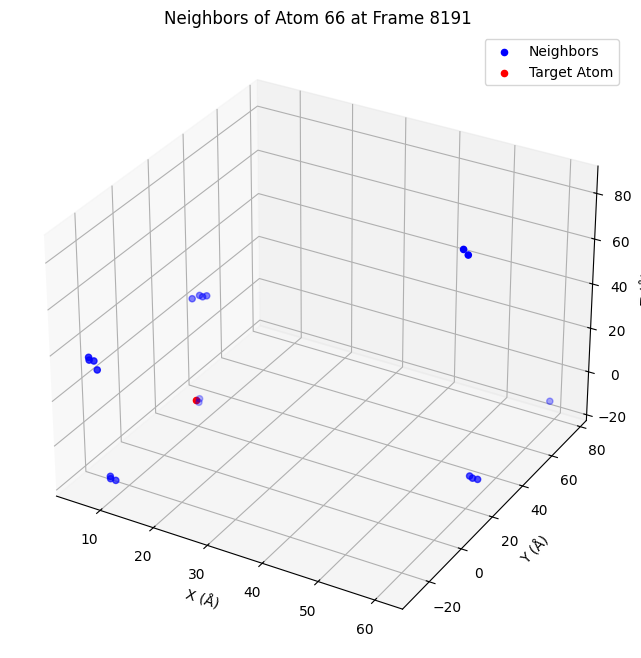

In [18]:
# unwrapped positions展示
fig= plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(neighbor_positions[:, 0], neighbor_positions[:, 1], neighbor_positions[:, 2], c='b', label='Neighbors')
ax.scatter(target_position[0], target_position[1], target_position[2], c='r', label='Target Atom')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx}')
ax.legend()
plt.show()

In [15]:
# wrapped positions展示
wrapped_positions = apply_PBC(neighbor_positions, u.dimensions)
wrapped_target_position = apply_PBC(target_position, u.dimensions)

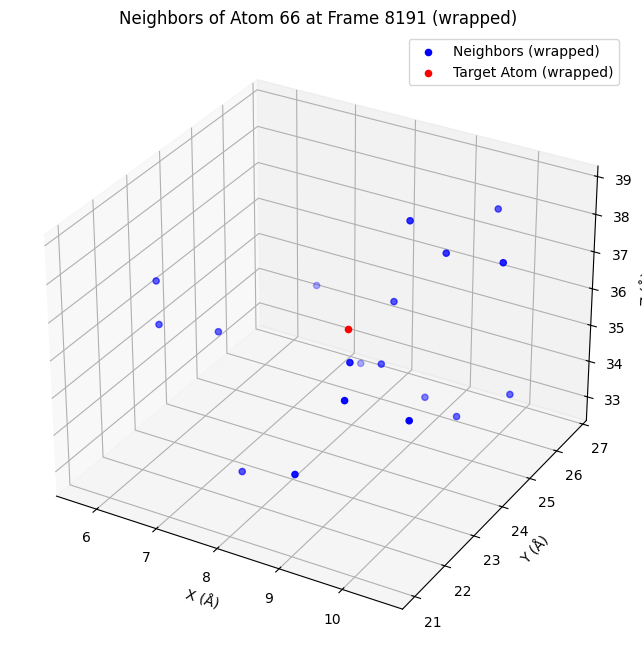

In [20]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wrapped_positions[:, 0], wrapped_positions[:, 1], wrapped_positions[:, 2], c='b', label='Neighbors (wrapped)')
ax.scatter(wrapped_target_position[0], wrapped_target_position[1], wrapped_target_position[2], c='r', label='Target Atom (wrapped)')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx} (wrapped)')
ax.legend()
plt.show()

In [23]:
# 展示与最近像原子的位置关系
dimensions = u.dimensions
for neighbor_idx, neighbor_pos in zip(neighbor_idxs, wrapped_positions):
    delta = wrapped_target_position - neighbor_pos
    print(f"Checking atom {neighbor_idx}: delta = {delta}")
    print(f"distance = {np.linalg.norm(delta)}")
    if np.any(np.abs(delta) > dimensions[:3] / 2):
        print(f"Atom {neighbor_idx} is closer in a periodic image.")
        image_shift = np.round(delta / dimensions[:3]) * dimensions[:3]
        actual_position = neighbor_pos + image_shift
        print(f"Actual position considering PBC: {actual_position}")

Checking atom 6352: delta = [0.7234392 2.0503006 2.7552986]
distance = 3.509810209274292
Checking atom 10135: delta = [ 2.5940294  1.1585999 -0.8832016]
distance = 2.975128173828125
Checking atom 10134: delta = [2.4070692  1.4413013  0.01200104]
distance = 2.805614948272705
Checking atom 8334: delta = [ 0.8106489 -2.1091995  2.8680992]
distance = 3.651283025741577
Checking atom 6100: delta = [ 1.7264471 -2.411501   1.2877998]
distance = 3.2333240509033203
Checking atom 10136: delta = [1.7367492  0.83180046 0.32099915]
distance = 1.9522371292114258
Checking atom 11942: delta = [-0.7804003  3.2938995  1.0788002]
distance = 3.5528311729431152
Checking atom 290: delta = [-0.8740597   1.7349014  -0.75370026]
distance = 2.0837292671203613
Checking atom 289: delta = [-2.1521502   2.4689999  -0.40810013]
distance = 3.300644636154175
Checking atom 288: delta = [-1.2185001   2.6082     -0.56679916]
distance = 2.934060573577881
Checking atom 7601: delta = [-2.0539503 -1.2818012  1.7327995]
distan

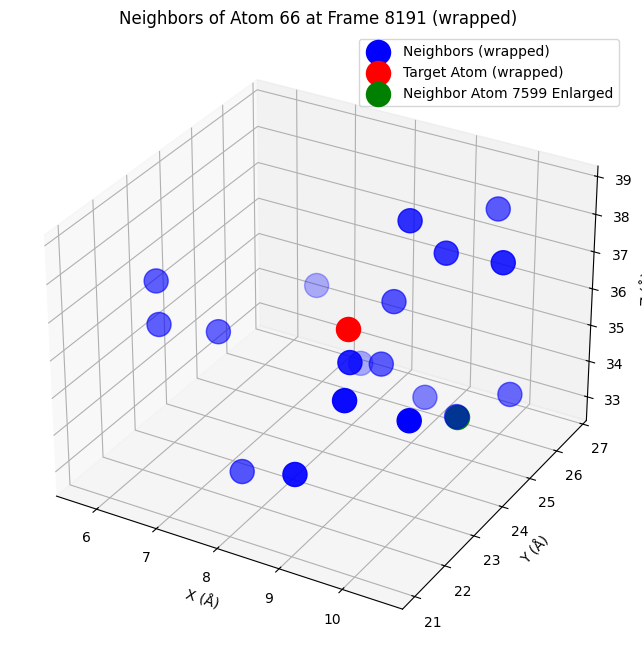

In [26]:
# 增加氧原子半径大小的可视化， 按照实际比例展示，一个氧原子大约0.66Å，对应图中的表示大小参数应该为300
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wrapped_positions[:, 0], wrapped_positions[:, 1], wrapped_positions[:, 2], s=300, c='b', label='Neighbors (wrapped)')
ax.scatter(wrapped_target_position[0], wrapped_target_position[1], wrapped_target_position[2], s=300, c='r', label='Target Atom (wrapped)')
ax.scatter(wrapped_positions[12, 0], wrapped_positions[12, 1], wrapped_positions[12, 2], s=300, c='g', label=f'Neighbor Atom {neighbor_idxs[12]} Enlarged')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title(f'Neighbors of Atom {target_idx} at Frame {frame_idx} (wrapped)')
ax.legend()
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

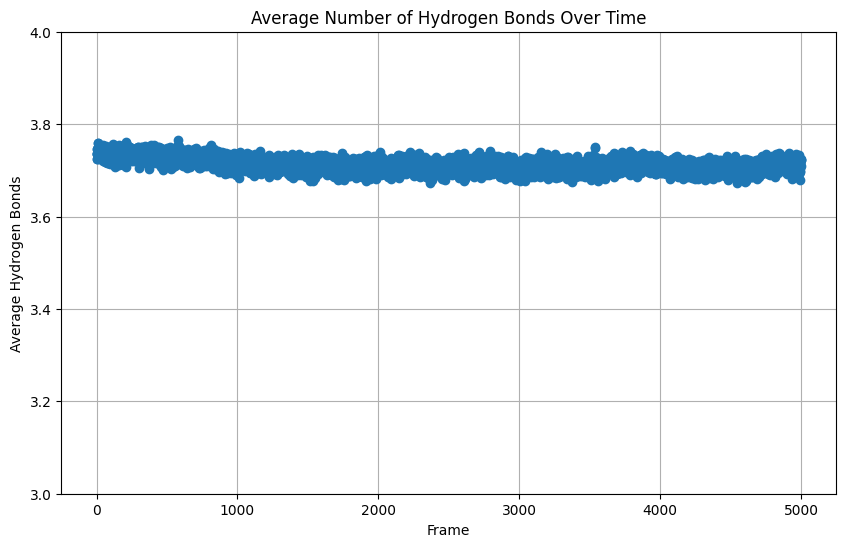

In [2]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/Ice/225/shear/rst/1e-6/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

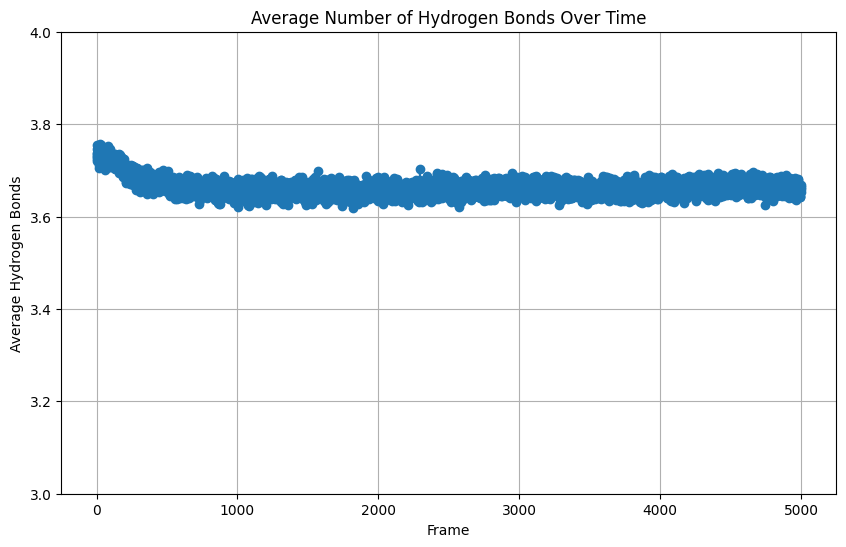

In [2]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/Ice/225/shear/rst/5e-6/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

HD5 file columns:
Index(['frame', 'donor', 'hydrogen', 'acceptor', 'distance', 'angle'], dtype='object')


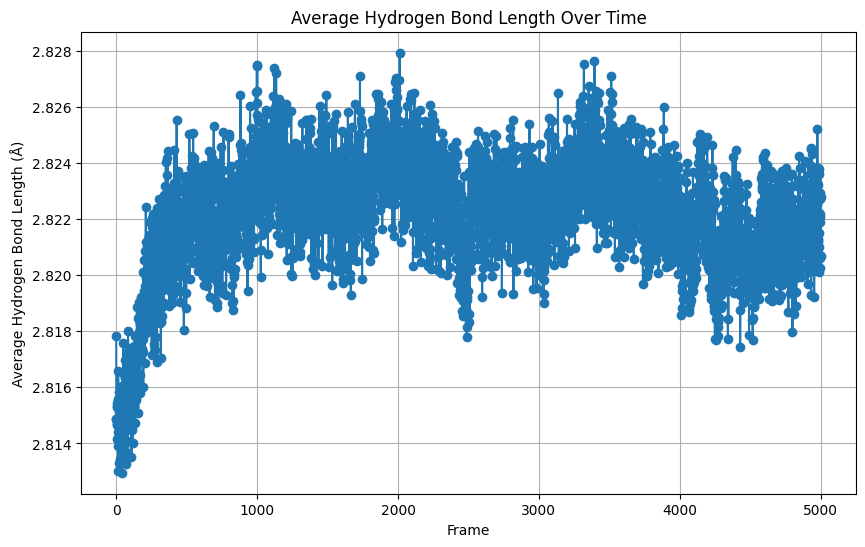

In [6]:
# 读取hbonds.h5文件，获取平均氢键长度的信息：
#     做氢键长度分布图
#     做氢键长度随时间变化图
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-6/hbonds.h5"
# 读取hbonds.h5文件的各列索引
print("HD5 file columns:")
hbonds_df = pd.read_hdf(file_path, key='hbonds')
print(hbonds_df.columns)
# 读取氢键长度数据
hbond_lengths = hbonds_df.groupby("frame")["distance"].mean()
# 绘制氢键长度随时间变化图
plt.figure(figsize=(10, 6))
plt.plot(hbond_lengths.index, hbond_lengths.values, marker='o', linestyle='-')
plt.title('Average Hydrogen Bond Length Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bond Length (Å)')
# plt.ylim(2.7, 3.2)
plt.grid()
plt.show()

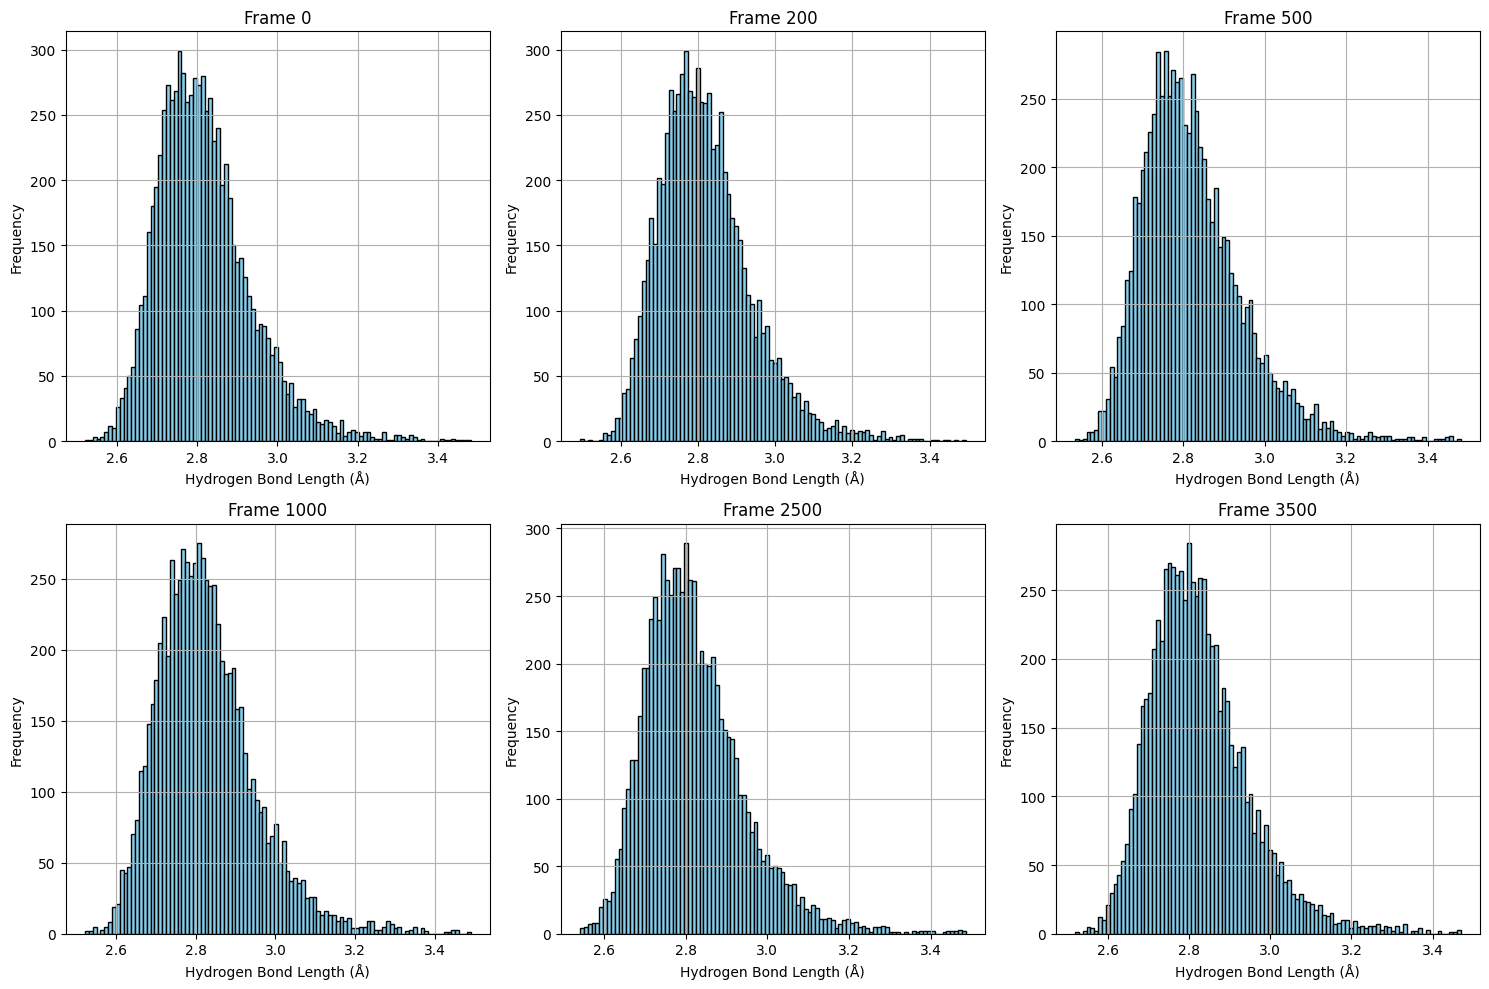

In [9]:
# 进一步展示氢键长度的分布情况，选择特定帧进行展示,做成子图形式，易于对比
specific_frames = [0, 200, 500, 1000, 2500, 3500]

plt.figure(figsize=(15, 10))
for i, frame in enumerate(specific_frames, 1):
    frame_data = hbonds_df[hbonds_df['frame'] == frame]
    plt.subplot(2, 3, i)
    plt.hist(frame_data['distance'], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Frame {frame}')
    plt.xlabel('Hydrogen Bond Length (Å)')
    plt.ylabel('Frequency')
    plt.grid()
plt.tight_layout()
plt.show()

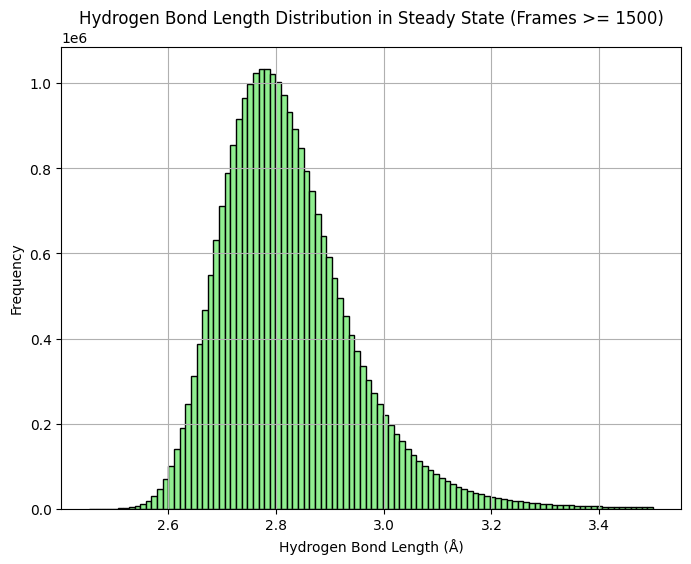

: 

In [ ]:
# 观察稳态下的氢键长度分布情况
steady_state_frames = hbonds_df[hbonds_df['frame'] >= 1500]
plt.figure(figsize=(8, 6))
plt.hist(steady_state_frames['distance'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Hydrogen Bond Length Distribution in Steady State (Frames >= 1500)')
plt.xlabel('Hydrogen Bond Length (Å)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

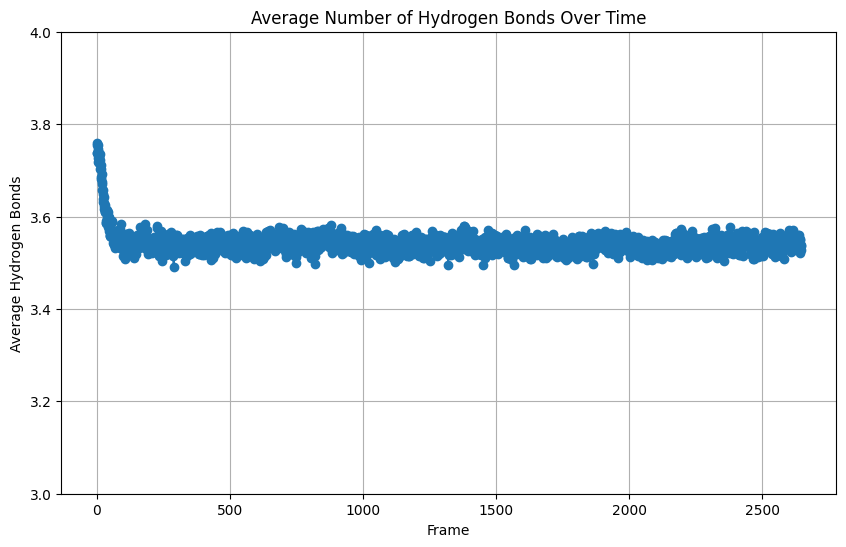

In [4]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/Ice/225/shear/rst/5e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

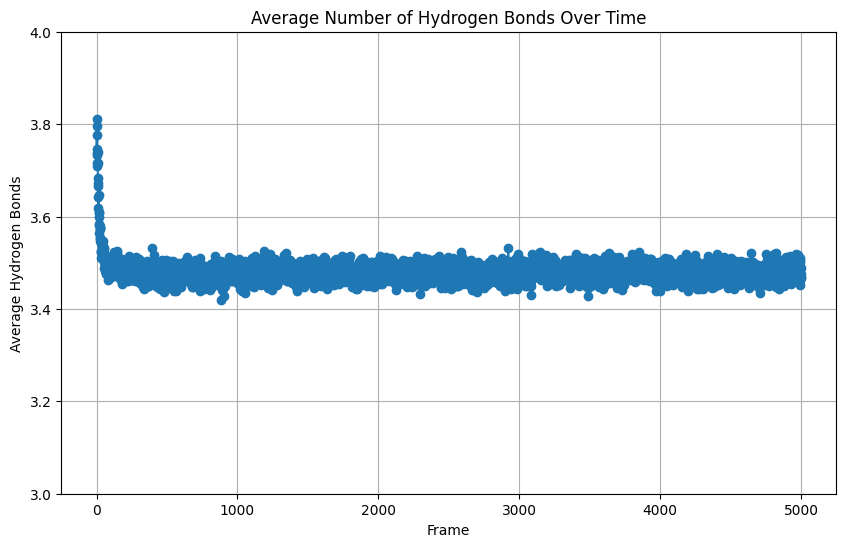

In [6]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

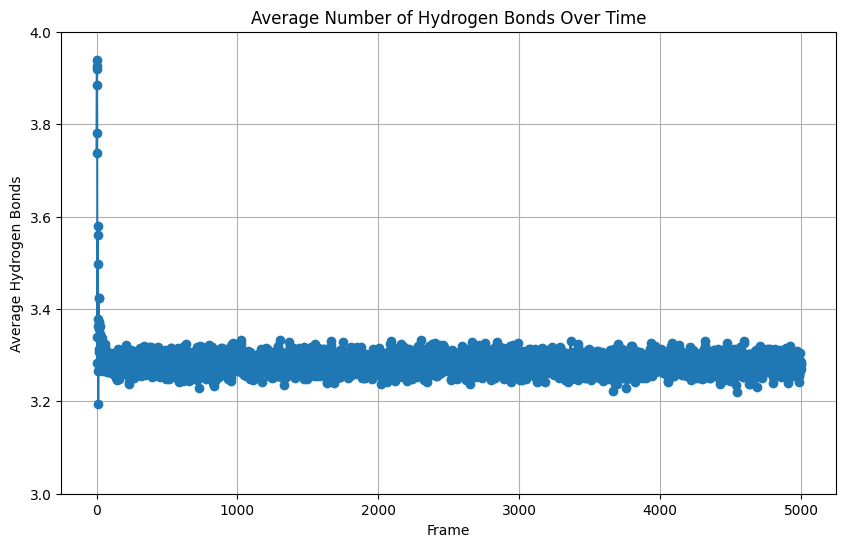

In [2]:
# 绘制氢键数量随时间变化的图表
data = pd.read_csv("/home/debian/water/TIP4P/Ice/225/shear/rst/5e-4/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

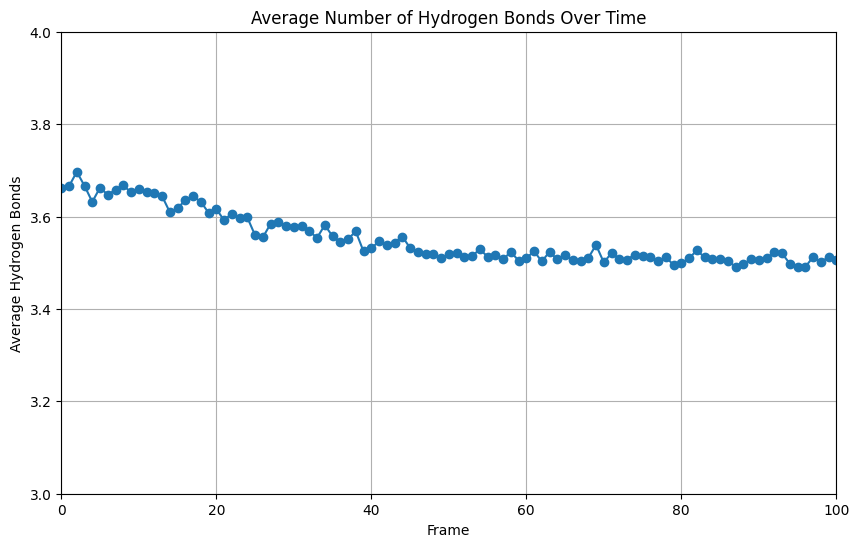

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/5e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.xlim(0,100)
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

In [3]:
print(hb_counts[0])
print(hb_counts[1000:].mean())

3.662109375
3.4846735277895204


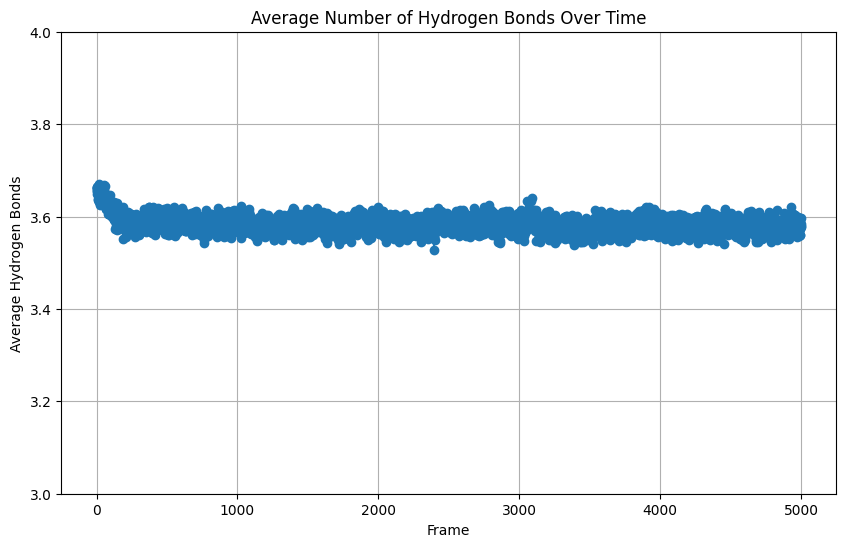

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/1e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
plt.ylabel('Average Hydrogen Bonds')
plt.ylim(3, 4)
plt.grid()
plt.show()

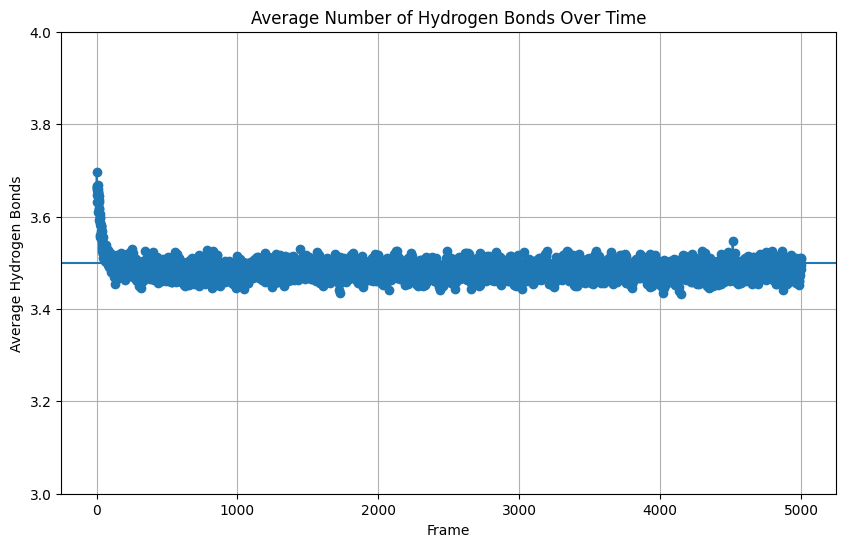

3.662109375
3.4846735277895204


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/5e-5/hb_counts_per_idx.csv")
hb_counts = data['hb_count'].groupby(data["frame"]).mean()
plt.figure(figsize=(10, 6))
plt.plot(hb_counts.index, hb_counts.values, marker='o', linestyle='-')
plt.title('Average Number of Hydrogen Bonds Over Time')
plt.xlabel('Frame')
# plt.xlim(0,200)
plt.ylabel('Average Hydrogen Bonds')
plt.axhline(y=3.5)
plt.ylim(3, 4)
plt.grid()
plt.show()
print(hb_counts[0])
print(hb_counts[1000:].mean())

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

zeta = pd.read_csv("/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta.csv",names=["frame","O_idx","distance"], header=0)
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

zeta_test.shape at frame 5000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 12
zeta_test.shape at frame 0: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 22
zeta_test.shape at frame 1000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 15
zeta_test.shape at frame 2000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 11
zeta_test.shape at frame 3000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 12
zeta_test.shape at frame 4000: (4096, 3)
numbers of distances not in range[-0.5, 1.5]: 15


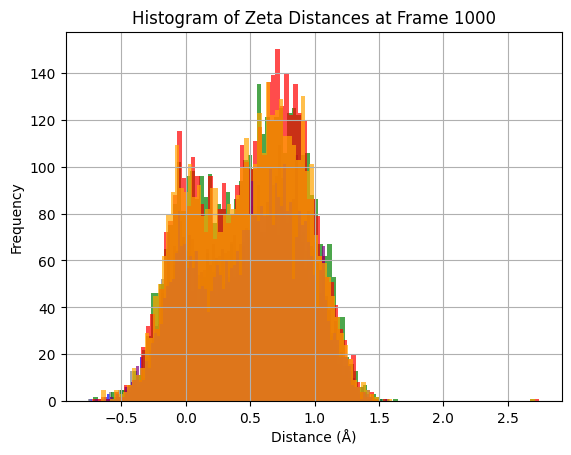

In [ ]:
zeta_test = zeta[zeta["frame"] == 5000]
print(f"zeta_test.shape at frame 5000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 5000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False,color='blue', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 0]
print(f"zeta_test.shape at frame 0: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 0: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='gray', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 1000]
print(f"zeta_test.shape at frame 1000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 1000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='green', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 2000]
print(f"zeta_test.shape at frame 2000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 2000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='red', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 3000]
print(f"zeta_test.shape at frame 3000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 3000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False, color='purple', alpha=0.7)
zeta_test = zeta[zeta["frame"] == 4000]
print(f"zeta_test.shape at frame 4000: {zeta_test.shape}")
print(f"numbers of distances not in range[-0.5, 1.5]: {np.sum((zeta_test['distance'] < -0.5) | (zeta_test['distance'] > 1.5))}")
print(f'check max and min distance and abnormal values at frame 4000: max={zeta_test["distance"].max()}, min={zeta_test["distance"].min()}')
plt.hist(zeta_test["distance"], bins=100, density=False,color='orange', alpha=0.7)
plt.title('Histogram of Zeta Distances at Frame 1000')
plt.xlabel('Distance (Å)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
data_x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data_y = np.array([8,4,3,3,4,1,3,2,2,1])
def func(p,x,y):
    return p[0] * np.exp(-x/p[1]) + p[2] - y
# 使用data对func进行拟合
p0 = [13,1.2, 2.1]
from scipy.optimize import leastsq
ret = leastsq(func, p0, args=(data_x, data_y))
print(ret)


(array([13.66364051,  1.14937173,  2.11504757]), 1)


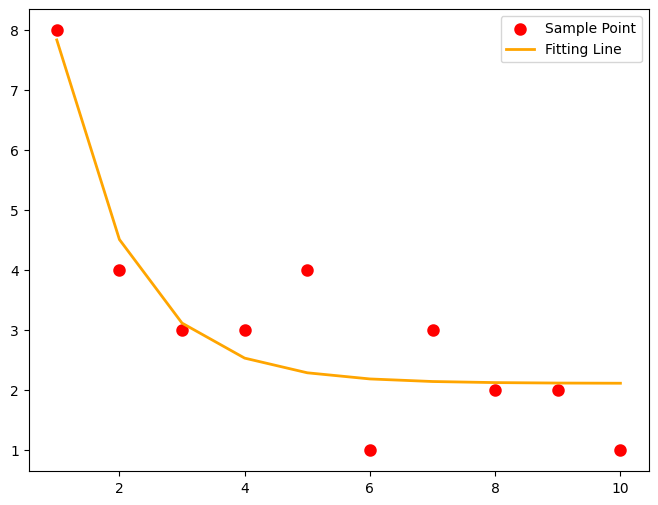

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(data_x,data_y,color="red",label="Sample Point",linewidth=3)
def f(p, x):
    return p[0] * np.exp(-x/p[1]) + p[2]

y = f(ret[0], data_x)

plt.plot(data_x,y,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

In [2]:
from scipy.stats import gaussian_kde
from scipy.stats import iqr
from scipy.signal import savgol_filter
def data_smooth(zeta):
        data = zeta["distance"].values[2000:]
        n = len(data)
                # 使用Silverman法则计算最优带宽
        silverman_bandwidth = 0.9 * min(np.std(data), iqr(data) / 1.34) * n ** (-0.2)
        print(f"Silverman带宽: {silverman_bandwidth:.6f}")
                # 使用高斯核密度估计
        kde = gaussian_kde(data, bw_method=silverman_bandwidth)
        window_length = 51 if n >= 51 else (n // 2) * 2 + 1  # 确保窗口长度为奇数且不超过数据点数
        polyorder = 3 if window_length > 3 else 2  # 多项式阶数小于窗口长度
        plt.figure(figsize=(10, 6))
        x = np.linspace(data.min(), data.max(), 1000)
        smoothed_kde = savgol_filter(kde(x), window_length=window_length, polyorder=polyorder)
                # plt.plot(x, kde(x), "-k", lw=2, label="KDE Estimate")
        plt.plot(x, smoothed_kde, "--b", lw=2, label="Smoothed KDE")
        hist, bin_edges, _ = plt.hist(
                data, bins=300, density=True, alpha=0.3, color="gray", label="Data Histogram"
                )
        plt.axvline(x=0, color="red", linestyle="--", label="ζ=0")
        plt.xlabel("Zeta Distance (nm)")
        plt.ylabel("Probability Density")
        plt.title("Kernel Density Estimation of Zeta Distance")
        plt.legend()
        return smoothed_kde, x
def P_rho(p, zeta):
    return np.exp(-(zeta - p[0])**2/(2 * p[1]**2)) / (p[1] * np.sqrt(2*np.pi))
def mixture_model(zeta, mu1, sigma1, mu2, sigma2, s):
    p1 = [mu1, sigma1]
    p2 = [mu2, sigma2]
    return (1 - s) * P_rho(p1, zeta) + s * P_rho(p2, zeta)
from scipy.optimize import minimize
from scipy.integrate import quad

In [3]:
def objective_function(params, zeta_values, kde_values, zeta_zero_density):
    """目标函数：同时拟合整体分布和ζ=0处的约束"""
    mu1, sigma1, mu2, sigma2, s = params
    
    # 约束1：整体分布拟合误差
    predicted_kde = mixture_model(zeta_values, mu1, sigma1, mu2, sigma2, s)
    fit_error = np.sum((predicted_kde - kde_values)**2)
    
    # 约束2：ζ=0处的密度约束
    density_at_zero = mixture_model(0, mu1, sigma1, mu2, sigma2, s)
    zero_constraint_error = (density_at_zero - zeta_zero_density)**2 * 1000  # 加权
    
    # 约束3：物理合理性约束（可选）
    # 确保sigma为正，s在[0,1]之间
    penalty = 0
    if sigma1 <= 0 or sigma2 <= 0 or s < 0 or s > 1:
        penalty += 1000
    
    return fit_error + zero_constraint_error + penalty

In [4]:
def solve_mixture_model(x, y, zeta_zero_density):
    """解决混合模型参数估计问题"""
    
    # 方法1：基于物理理解的初始猜测
    # 观察您的KDE图形，猜测两个高斯分量的位置
    # 例如：一个在0附近，一个在某个特征位置
    
    # 手动调节寻找峰值作为参考
    peak1_pos = x[np.argmax(y)]
    peak2_pos = 0
    
    
    # 初始参数猜测 [mu1, sigma1, mu2, sigma2, s]
    initial_guess = [peak2_pos, 1.0, peak1_pos, 1.0, 0.3]
    
    # 参数边界
    bounds = [
        (x.min(), x.max()),  # mu1范围
        (0.1, 10),           # sigma1范围
        (x.min(), x.max()),  # mu2范围
        (0.1, 10),           # sigma2范围
        (0, 1)               # s在[0,1]之间
    ]
    
    # 优化
    result = minimize(
        objective_function,
        initial_guess,
        args=(x, y, zeta_zero_density),
        bounds=bounds,
        method='L-BFGS-B',
        options={"maxiter":1000}
    )
    
    if result.success:
        mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt = result.x
        
        # 验证结果
        predicted_at_zero = mixture_model(0, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt)
        fit_quality = np.sqrt(np.mean((mixture_model(x, mu1_opt, sigma1_opt, mu2_opt, sigma2_opt, s_opt) - y)**2))
        
        print("=== 参数估计结果 ===")
        print(f"第一个高斯分量: μ1 = {mu1_opt:.4f}, σ1 = {sigma1_opt:.4f}")
        print(f"第二个高斯分量: μ2 = {mu2_opt: .4f}, σ2 = {sigma2_opt:.4f}")
        print(f"混合系数 s = {s_opt:.4f} (第二个分量的权重)")
        print(f"约束验证: P(ζ=0) = {predicted_at_zero:.6f} (目标: {zeta_zero_density:.6f})")
        print(f"拟合均方根误差: {fit_quality:.6f}")
        
        return result.x
    else:
        print("优化失败:", result.message)
        return None

# 使用示例
# estimated_params = solve_mixture_model(x, y, zeta_zero_density)

# 可视化结果
def plot_results(x, y, params, zeta_zero_density):
    """绘制拟合结果"""
    mu1, sigma1, mu2,sigma2, s = params
    
    plt.figure(figsize=(12, 8))
    
    # 原始数据
    plt.plot(x, y, 'k-', lw=2, label='原始KDE', alpha=0.7)
    
    # 拟合结果
    y_fit = mixture_model(x, mu1, sigma1, mu2, sigma2, s)
    plt.plot(x, y_fit, 'r--', lw=2, label='双高斯混合拟合')
    
    # 各个分量
    y1 = (1 - s) * P_rho([mu1, sigma1], x)
    y2 = s * P_rho([mu2, sigma2], x)
    plt.plot(x, y1, 'b:', lw=1, label=f'分量1 (权重: {1-s:.3f})')
    plt.plot(x, y2, 'g:', lw=1, label=f'分量2 (权重: {s:.3f})')
    
    # ζ=0处的约束点
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='ζ=0')
    plt.scatter(0, zeta_zero_density, color='red', s=100, zorder=5, 
                label=f'约束点: P(0)={zeta_zero_density:.4f}')
    
    plt.xlabel('Zeta Distance)')
    plt.ylabel('Probability Density')
    plt.title('双高斯混合模型拟合结果')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 调用绘图
# if estimated_params is not None:
#     plot_results(x, y, estimated_params, zeta_zero_density)

1. constraint：kde(0)处只有P_rho贡献

2. constraint：全部的kde可以用两个P来叠加拟合

(1-s) * P_rho(p1, zeta) + s * P_rho(p2, zeta) = kde(zeta)

Silverman带宽: 0.012615
ζ=0处的真实概率密度值: 0.653532
=== 参数估计结果 ===
第一个高斯分量: μ1 = 0.7038, σ1 = 0.3035
第二个高斯分量: μ2 =  0.0027, σ2 = 0.1776
混合系数 s = 0.2613 (第二个分量的权重)
约束验证: P(ζ=0) = 0.652672 (目标: 0.653532)
拟合均方根误差: 0.018206


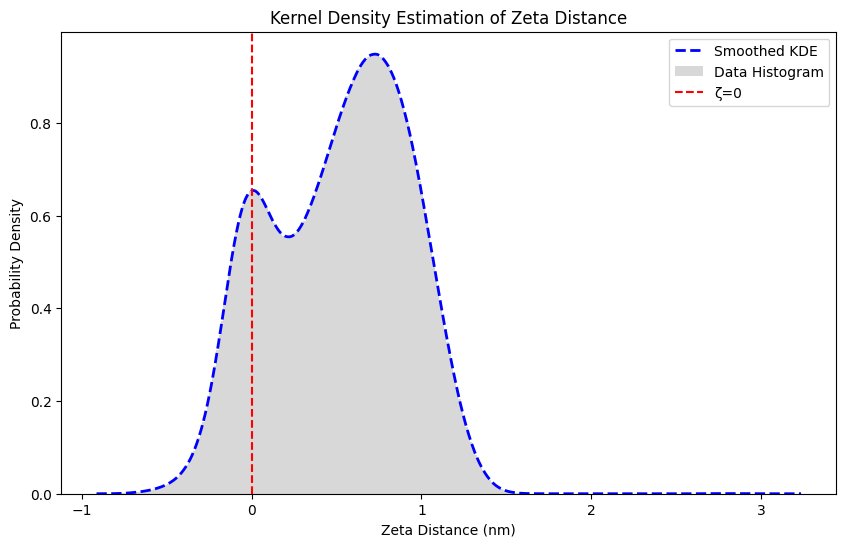

/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

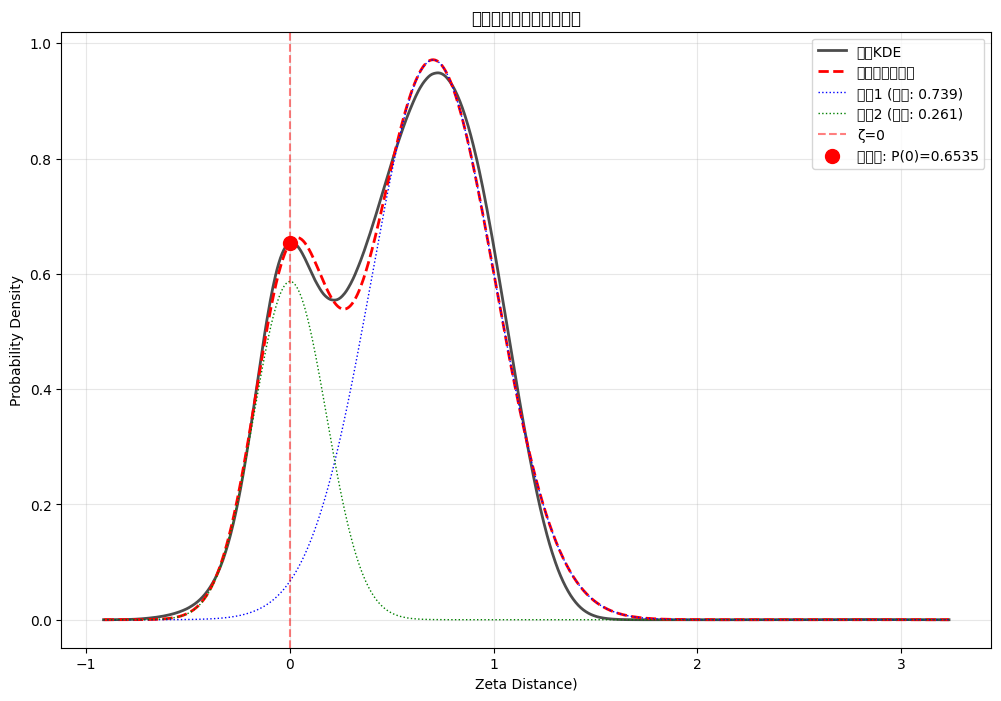

Silverman带宽: 0.012401
ζ=0处的真实概率密度值: 0.735238
=== 参数估计结果 ===
第一个高斯分量: μ1 = 0.6506, σ1 = 0.3071
第二个高斯分量: μ2 = -0.0040, σ2 = 0.1768
混合系数 s = 0.2818 (第二个分量的权重)
约束验证: P(ζ=0) = 0.734618 (目标: 0.735238)
拟合均方根误差: 0.013749


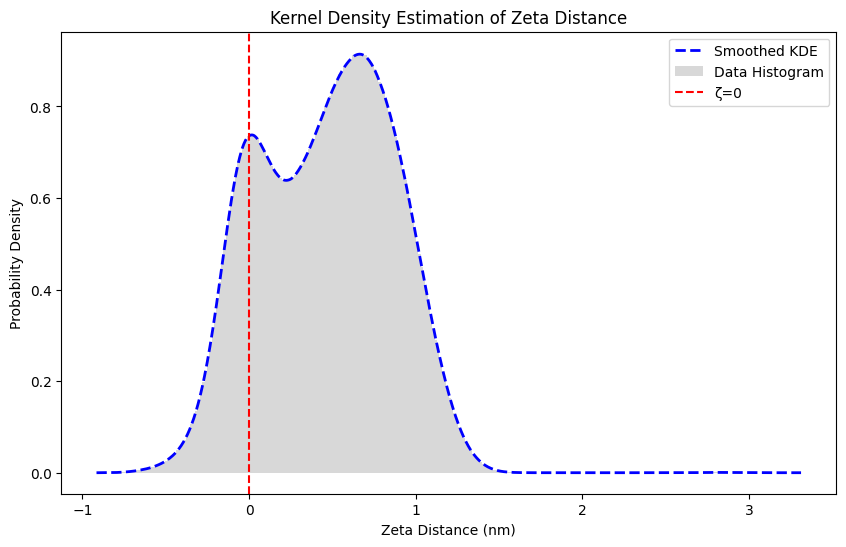

/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

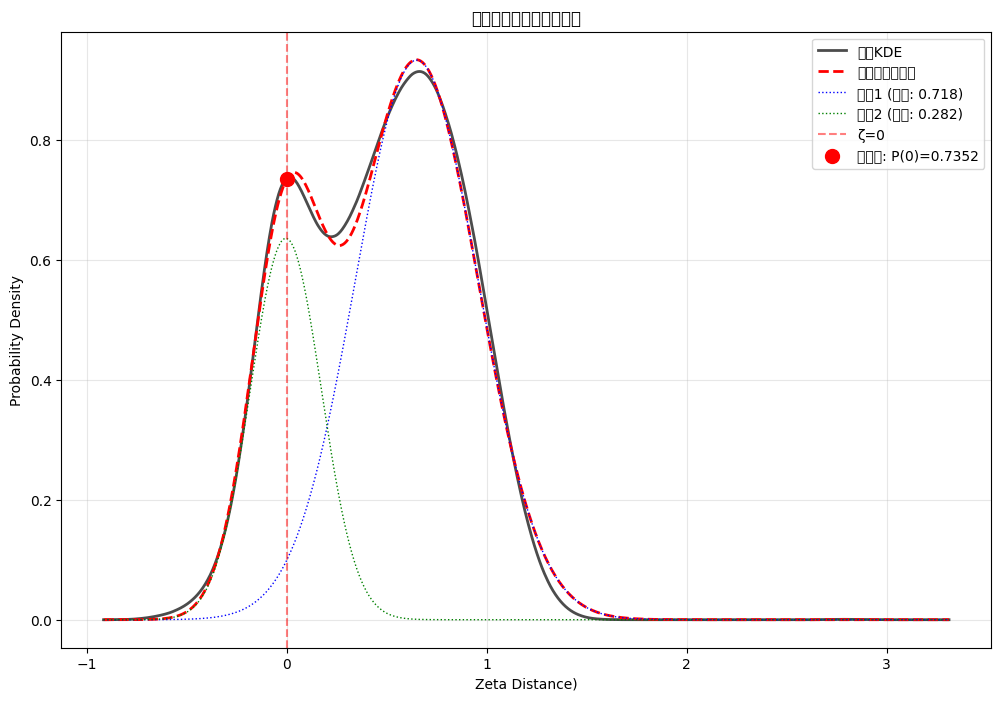

Silverman带宽: 0.011597
ζ=0处的真实概率密度值: 1.003210
=== 参数估计结果 ===
第一个高斯分量: μ1 = -0.0139, σ1 = 0.1787
第二个高斯分量: μ2 =  0.4855, σ2 = 0.3266
混合系数 s = 0.6716 (第二个分量的权重)
约束验证: P(ζ=0) = 1.002667 (目标: 1.003210)
拟合均方根误差: 0.008334


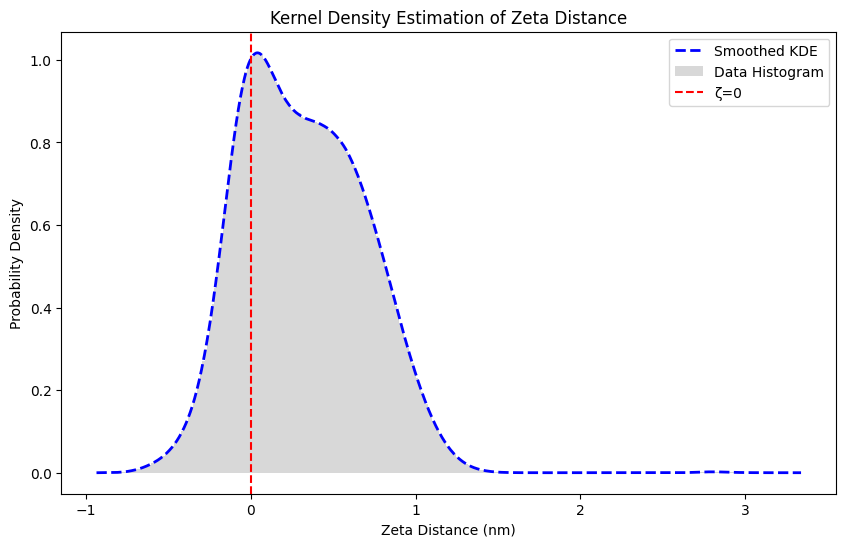

/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

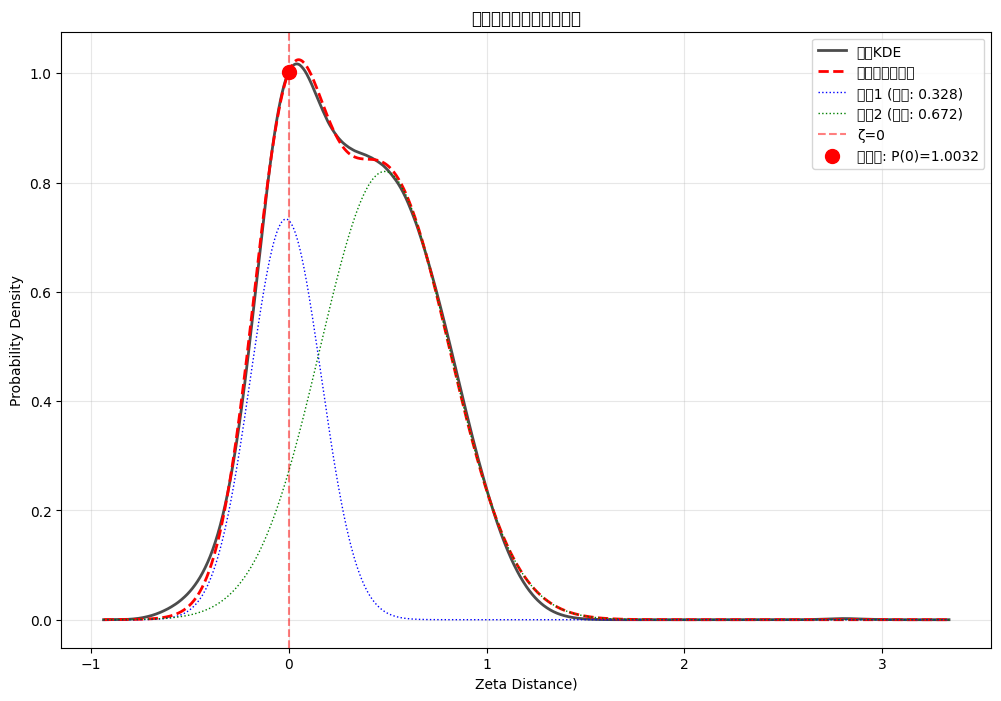

Silverman带宽: 0.010677
ζ=0处的真实概率密度值: 1.238035
=== 参数估计结果 ===
第一个高斯分量: μ1 = 0.0026, σ1 = 0.1625
第二个高斯分量: μ2 =  0.2782, σ2 = 0.3543
混合系数 s = 0.7478 (第二个分量的权重)
约束验证: P(ζ=0) = 1.237779 (目标: 1.238035)
拟合均方根误差: 0.003807


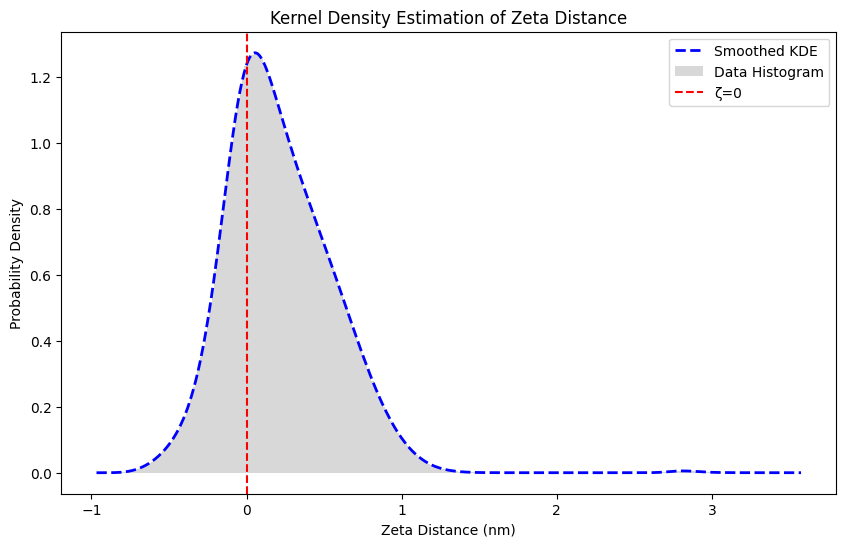

/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21452 (\N{CJK UNIFIED IDEOGRAPH-53CC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26031 (\N{CJK UNIFIED IDEOGRAPH-65AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missin

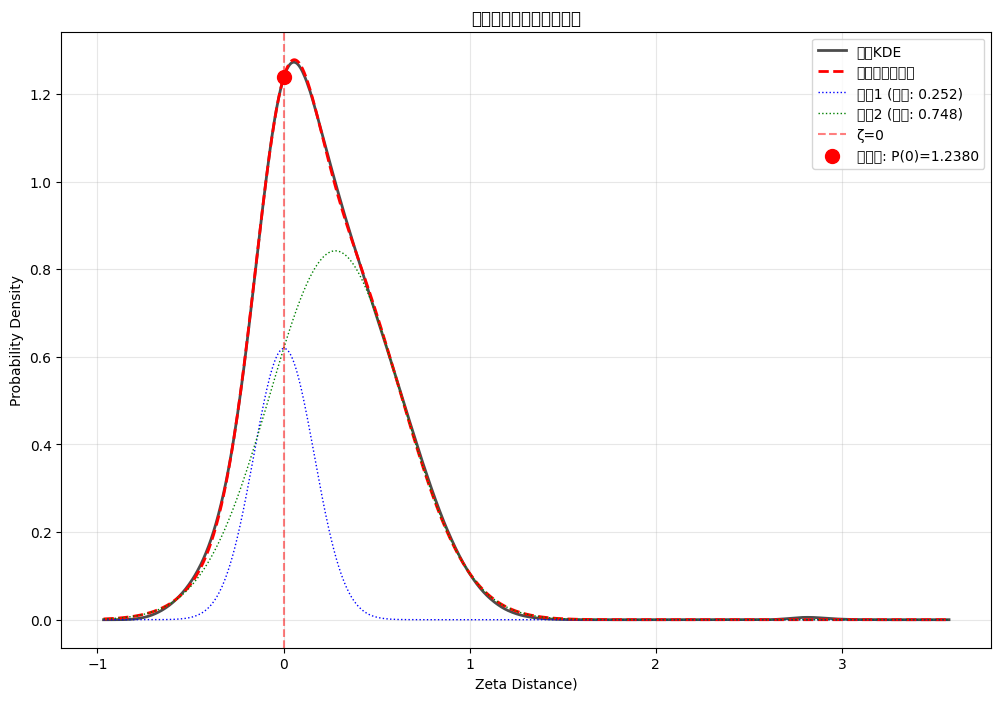

In [5]:
for zeta_file in [
                  "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-6/zeta.csv",
                  "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-6/zeta.csv",
                  "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/zeta.csv",
                  "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-4/zeta.csv"]:
    zeta = pd.read_csv(zeta_file, names=["frame", "O_idx", "distance"],
            header=0)
    smoothed_kde, x = data_smooth(zeta)
    zeta_zero_density = smoothed_kde[np.argmin(np.abs(x - 0))]
    print(f"ζ=0处的真实概率密度值: {zeta_zero_density:.6f}")
    estimated_params = solve_mixture_model(x, smoothed_kde, zeta_zero_density)
    plot_results(x, smoothed_kde, estimated_params, zeta_zero_density)

In [8]:
# 追踪一个粒子zeta_cg的变化情况
import pandas as pd
cg_file = "/home/debian/water/TIP4P/2005/nvt/rst/equili/zeta_cg.csv"
zeta_cg = pd.read_csv(cg_file,names=["frame", "O_idx", "zeta_cg"],header=0)
print(zeta_cg)

          frame  O_idx   zeta_cg
0             0      3  0.424223
1             0      6  0.414841
2             0      9  0.260171
3             0     12  0.263483
4             0     15  0.631681
...         ...    ...       ...
20484090   5000  12273  0.721948
20484091   5000  12276  0.630887
20484092   5000  12279  0.972331
20484093   5000  12282  0.266766
20484094   5000  12285  0.376505

[20484095 rows x 3 columns]


In [15]:
zeta_cg_grouped = zeta_cg.groupby("O_idx").apply(lambda x: x)
print(zeta_cg_grouped.head())

             frame  O_idx   zeta_cg
O_idx                              
0     4095       1      0  0.504910
      8191       2      0  0.751531
      12287      3      0  0.775692
      16383      4      0  0.670847
      20479      5      0  0.469326


/tmp/ipykernel_15535/4103939783.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zeta_cg_grouped = zeta_cg.groupby("O_idx").apply(lambda x: x)


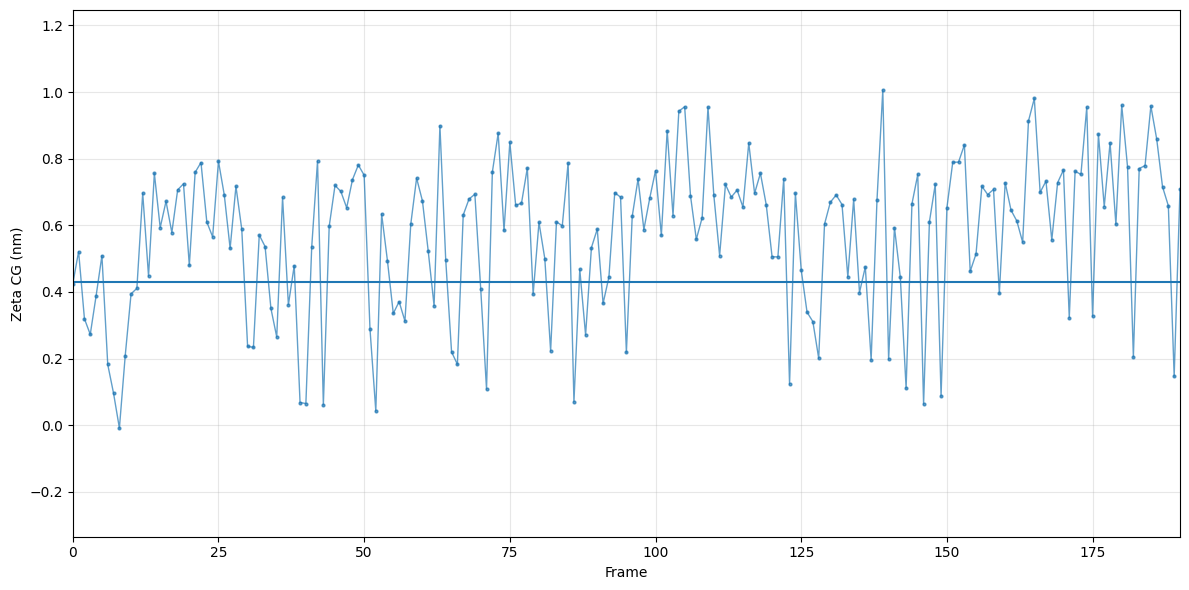

O_idx=3的统计信息:
数据点数: 5001
Frame范围: 0 - 5000
Zeta CG范围: -0.263 - 1.174 nm
Zeta CG均值: 0.583 nm
Zeta CG标准差: 0.250 nm


In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_oidx_vs_frame(df, o_idx, figsize=(12, 6)):
    """
    绘制特定O_idx随frame变化的折线图
    
    Parameters:
    df: DataFrame包含frame, O_idx, zeta_cg三列
    o_idx: 要观察的O_idx值
    figsize: 图形大小
    """
    # 筛选特定O_idx的数据
    oidx_data = df[df['O_idx'] == o_idx].copy()
    
    if len(oidx_data) == 0:
        print(f"未找到O_idx={o_idx}的数据")
        return
    
    # 按frame排序
    oidx_data = oidx_data.sort_values('frame')
    
    plt.figure(figsize=figsize)
    plt.plot(oidx_data['frame'], oidx_data['zeta_cg'], 
             marker='o', markersize=2, linewidth=1, alpha=0.7)
    plt.axhline(y=0.43)
    plt.xlabel('Frame')
    plt.ylabel('Zeta CG (nm)')
    plt.xlim(0, 190)
    # plt.title(f'O_idx = {o_idx} 的Zeta距离随Frame变化')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 输出统计信息
    print(f"O_idx={o_idx}的统计信息:")
    print(f"数据点数: {len(oidx_data)}")
    print(f"Frame范围: {oidx_data['frame'].min()} - {oidx_data['frame'].max()}")
    print(f"Zeta CG范围: {oidx_data['zeta_cg'].min():.3f} - {oidx_data['zeta_cg'].max():.3f} nm")
    print(f"Zeta CG均值: {oidx_data['zeta_cg'].mean():.3f} nm")
    print(f"Zeta CG标准差: {oidx_data['zeta_cg'].std():.3f} nm")

# 使用示例
plot_oidx_vs_frame(zeta_cg, o_idx=3)  # 观察O_idx=3的变化

/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 31163 (\N{CJK UNIFIED IDEOGRAPH-79BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_15535/370234032.py:29: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/debian/myenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: G

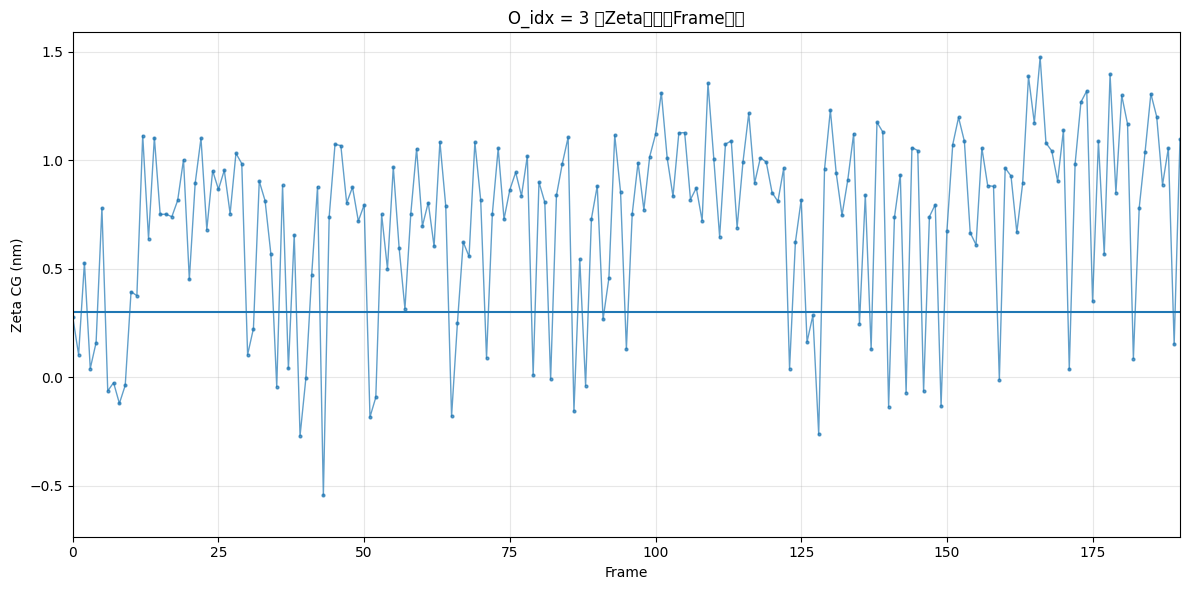

O_idx=3的统计信息:
数据点数: 5001
Frame范围: 0 - 5000
Zeta CG范围: -0.629 - 1.484 nm
Zeta CG均值: 0.624 nm
Zeta CG标准差: 0.411 nm


In [22]:
def plot_frame(df, o_idx, figsize=(12, 6)):
    """
    绘制特定O_idx随frame变化的折线图
    
    Parameters:
    df: DataFrame包含frame, O_idx, zeta_cg三列
    o_idx: 要观察的O_idx值
    figsize: 图形大小
    """
    # 筛选特定O_idx的数据
    oidx_data = df[df['O_idx'] == o_idx].copy()
    
    if len(oidx_data) == 0:
        print(f"未找到O_idx={o_idx}的数据")
        return
    
    # 按frame排序
    oidx_data = oidx_data.sort_values('frame')
    
    plt.figure(figsize=figsize)
    plt.plot(oidx_data['frame'], oidx_data['distance'], 
             marker='o', markersize=2, linewidth=1, alpha=0.7)
    plt.axhline(y=0.3)
    plt.xlabel('Frame')
    plt.ylabel('Zeta CG (nm)')
    plt.xlim(0, 190)
    plt.title(f'O_idx = {o_idx} 的Zeta距离随Frame变化')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 输出统计信息
    print(f"O_idx={o_idx}的统计信息:")
    print(f"数据点数: {len(oidx_data)}")
    print(f"Frame范围: {oidx_data['frame'].min()} - {oidx_data['frame'].max()}")
    print(f"Zeta CG范围: {oidx_data['distance'].min():.3f} - {oidx_data['distance'].max():.3f} nm")
    print(f"Zeta CG均值: {oidx_data['distance'].mean():.3f} nm")
    print(f"Zeta CG标准差: {oidx_data['distance'].std():.3f} nm")

plot_frame(zeta, o_idx=3)  # 观察O_idx=3的变化

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [ ]:
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hbonds.h5"
hbonds_df = pd.read_hdf(file_path, "hbonds")
target_idxs = [3429, 7230]

In [6]:
group = hbonds_df[hbonds_df["frame"] == 2000]
counter = 0
for target_idx in target_idxs:
    print(target_idx)
    print('acceptor')
    print(group[group["acceptor"] == target_idx])
    print('donor')
    print(group[group["donor"] == target_idx])

3429
acceptor
Empty DataFrame
Columns: [frame, donor, hydrogen, acceptor, distance, angle]
Index: []
donor
Empty DataFrame
Columns: [frame, donor, hydrogen, acceptor, distance, angle]
Index: []
7230
acceptor
Empty DataFrame
Columns: [frame, donor, hydrogen, acceptor, distance, angle]
Index: []
donor
Empty DataFrame
Columns: [frame, donor, hydrogen, acceptor, distance, angle]
Index: []


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# $\epsilon$分析

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 2501/2501 [01:47<00:00, 23.30it/s]


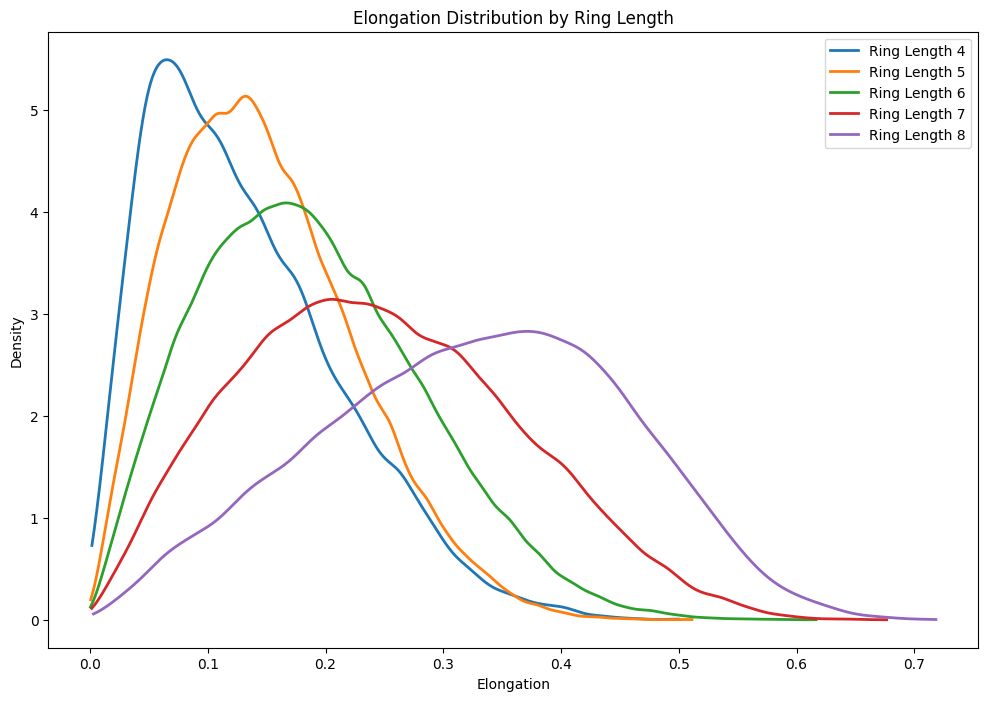

In [1]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/dump_225_test.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/rst/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result1 = pd.DataFrame()
for frame in range(0, 2500, 50):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result1 = pd.concat([result1, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result1['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result1[result1['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [03:23<00:00, 24.55it/s]


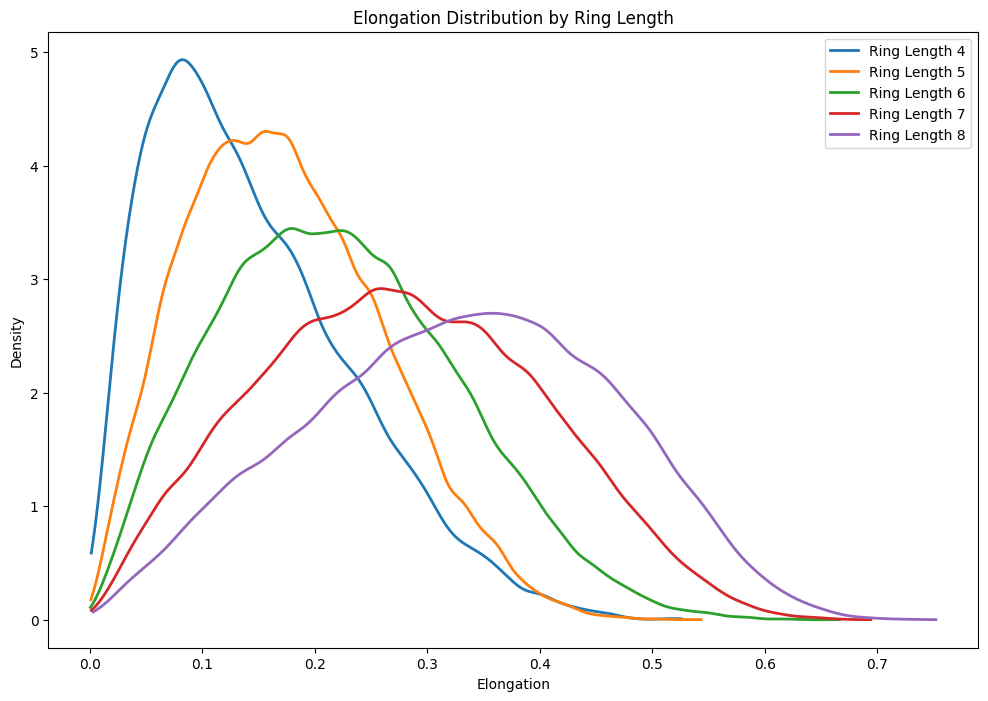

In [1]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_1e-4_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result2 = pd.DataFrame()
for frame in range(1000, 5000, 100):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result2 = pd.concat([result2, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result2['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result2[result2['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data:   8%|▊         | 408/5001 [00:16<03:10, 24.11it/s]

Loading trajectory data: 100%|██████████| 5001/5001 [03:27<00:00, 24.13it/s]


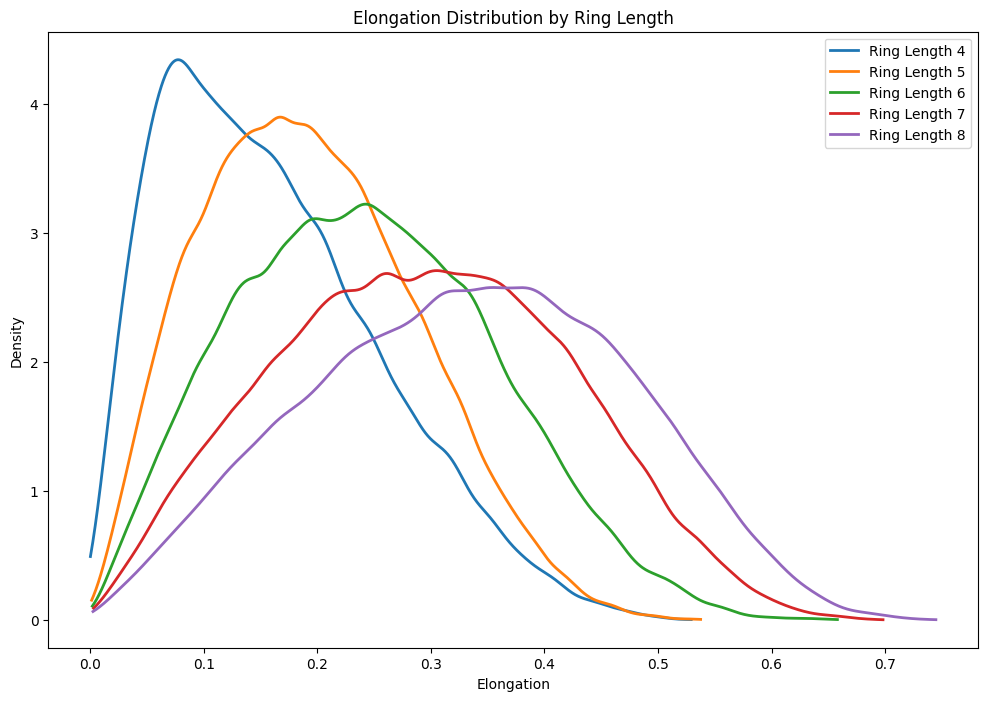

In [3]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-4_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-4/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result3 = pd.DataFrame()
for frame in range(1000, 5000, 100):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result3 = pd.concat([result3, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result3['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result3[result3['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data:  17%|█▋        | 873/5001 [00:35<02:46, 24.78it/s]

Loading trajectory data: 100%|██████████| 5001/5001 [03:23<00:00, 24.55it/s]


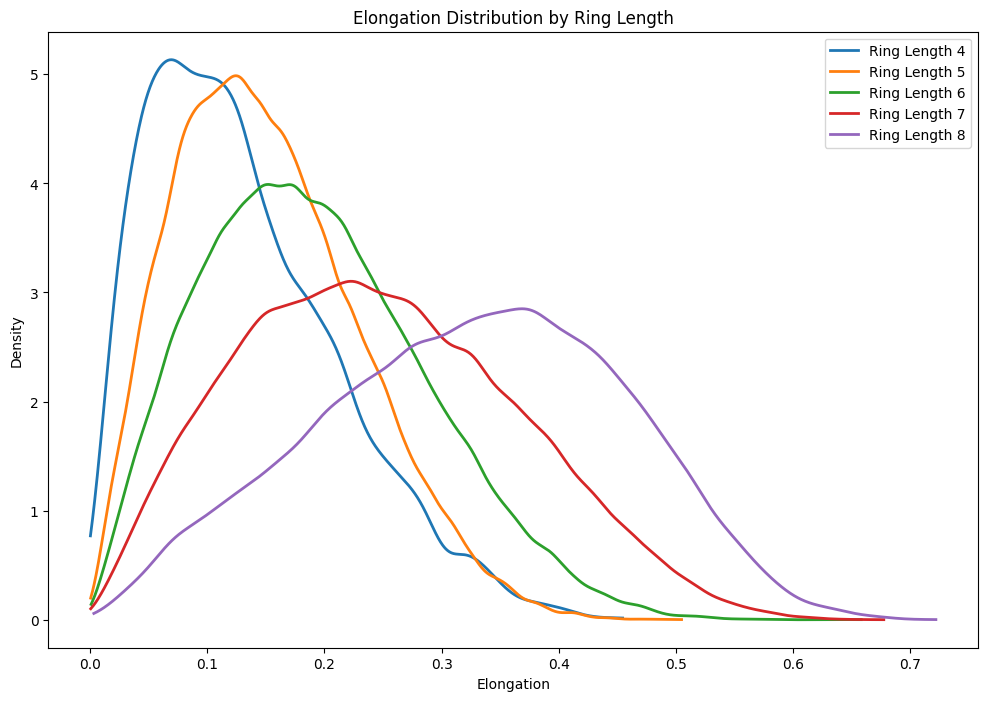

In [4]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_1e-6_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-6/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result4 = pd.DataFrame()
for frame in range(1000, 5000, 100):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result4 = pd.concat([result4, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result4['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result4[result4['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data:   1%|          | 36/5001 [00:01<03:21, 24.60it/s]

Loading trajectory data: 100%|██████████| 5001/5001 [03:31<00:00, 23.66it/s]


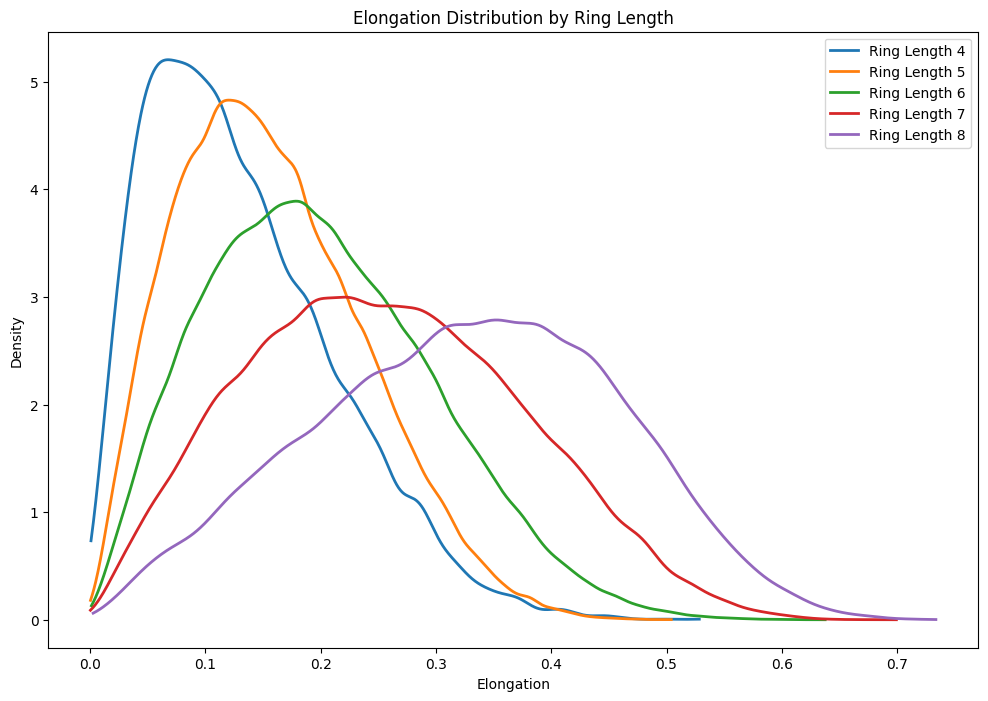

In [5]:
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-6_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-6/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result5 = pd.DataFrame()
for frame in range(1000, 5000, 100):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result5 = pd.concat([result5, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result5['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result5[result5['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
Loading trajectory data: 100%|██████████| 5001/5001 [03:26<00:00, 24.18it/s]


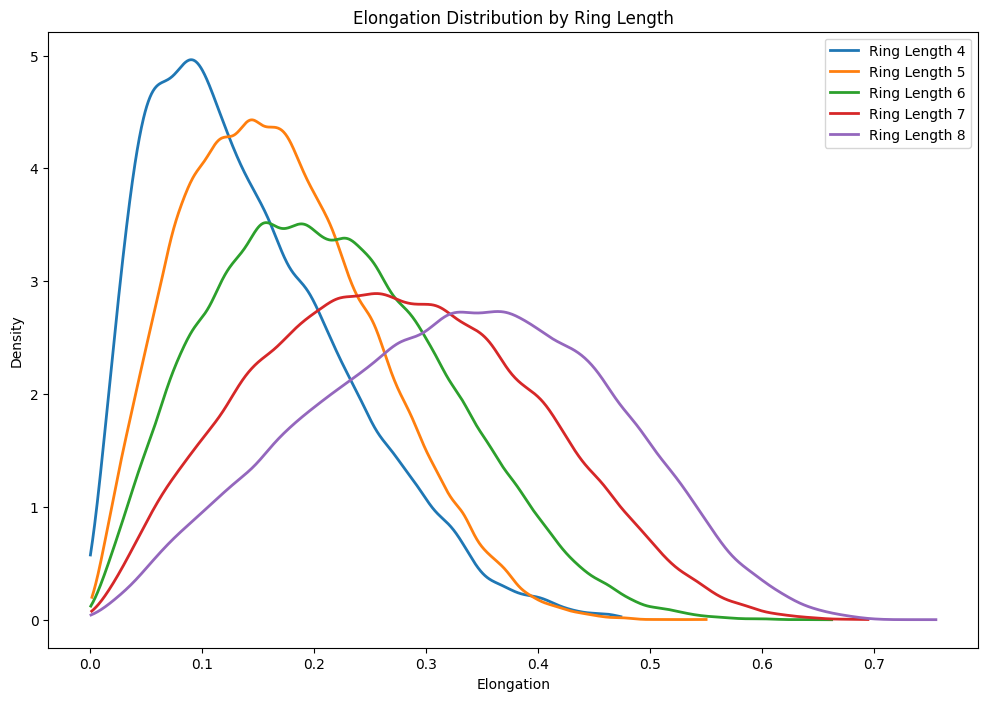

In [1]:
from hb_network import SingleNetworkAnalyzer, NetworkAnalyzer
import MDAnalysis as mda
u = mda.Universe("/home/debian/water/TIP4P/Ice/225/shear/traj_5e-5_225.0.lammpstrj", format="LAMMPSDUMP")
single_analyzer = SingleNetworkAnalyzer(u)
import pandas as pd
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/5e-5/hbonds.h5"
analyzer = NetworkAnalyzer(file_path)
# 增加分析粒子环的信息：多取帧数进行统计分析
result6 = pd.DataFrame()
for frame in range(1000, 5000, 100):
    particle_ring_df = analyzer.particle_ring_table(frame=frame, min_ring=3, max_ring=10)
    coords = single_analyzer.coords[frame] # 获取该时间帧的坐标
    box = single_analyzer.boxes[frame]  # 获取该时间帧的盒子尺寸
    df = single_analyzer.add_ring_shape_columns(particle_ring_df, coords, box)
    result6 = pd.concat([result6, df], ignore_index=True)
# 绘制ring_len 在不同情况下的elongation分布图
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
ring_lengths = sorted(result6['ring_len'].unique())
plt.figure(figsize=(12, 8))
for ring_len in ring_lengths:
    if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
        continue
    subset = result6[result6['ring_len'] == ring_len]
    kde = gaussian_kde(subset['elongation'])
    x_min = subset['elongation'].min()
    x_max = subset['elongation'].max()
    x = np.linspace(x_min, x_max, 1000)
    plt.plot(x, kde(x), label=f'Ring Length {ring_len}', linewidth=2)
    # plt.hist(subset['elongation'], bins=100, density=True, alpha=0.5, label=f'Ring Length {ring_len}')

plt.xlabel('Elongation')
plt.ylabel('Density')
plt.title('Elongation Distribution by Ring Length')
plt.legend()
plt.show()

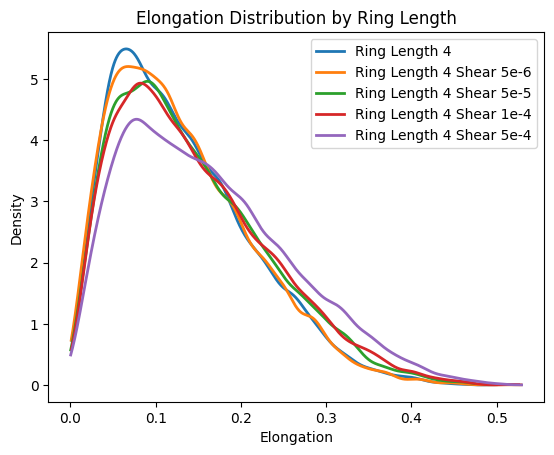

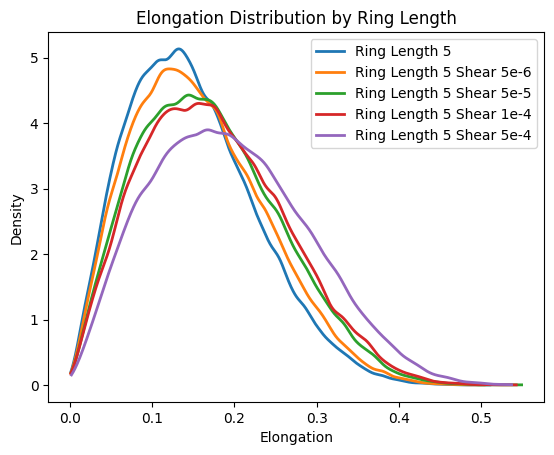

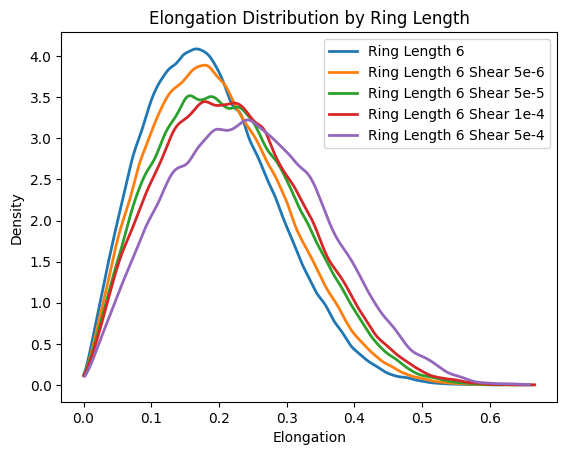

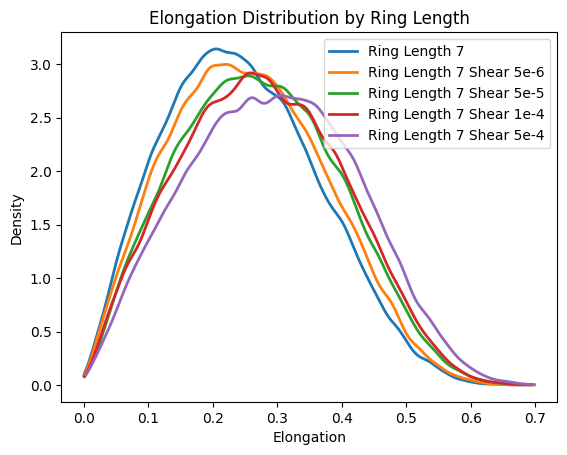

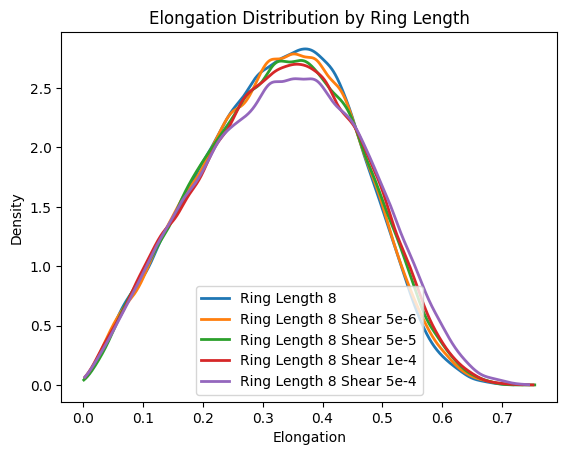

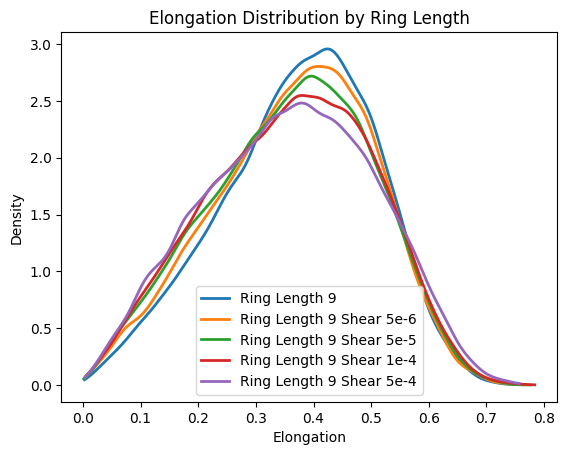

In [7]:
ring_lengths = sorted(result1['ring_len'].unique())
# 控制每个result的线型和颜色
ring_lengths = [4, 
                5, 6, 7, 8, 9
                ]
colors = ['blue', 
          'green', 'red', 'purple', 'orange', 'brown'
          ]
for ring_len, color in zip(ring_lengths, colors):
    
    # if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
    #     continue
    def plot_kde(data, ring_len, linestyle, label, color):
        subset = data[data['ring_len'] == ring_len]
        kde = gaussian_kde(subset['elongation'])
        x_min = subset['elongation'].min()
        x_max = subset['elongation'].max()
        x = np.linspace(x_min, x_max, 1000)
        plt.plot(x, kde(x), label=label, linewidth=2)
    plot_kde(result1, ring_len, '-', f'Ring Length {ring_len}', color)
    plot_kde(result5, ring_len, '--', f'Ring Length {ring_len} Shear 5e-6', color)
    plot_kde(result6, ring_len, '--', f'Ring Length {ring_len} Shear 5e-5', color)
    plot_kde(result2, ring_len, '--', f'Ring Length {ring_len} Shear 1e-4', color)
    plot_kde(result3, ring_len, '--', f'Ring Length {ring_len} Shear 5e-4', color)
    plt.xlabel('Elongation')
    plt.ylabel('Density')
    plt.title('Elongation Distribution by Ring Length')
    plt.legend()
    plt.show()

In [8]:
print(result1.head())
print(len(result1["frame"].unique()))

   frame  center  ring_len                                         ring_nodes  \
0      0       0         8  (0, 978, 8712, 6570, 8307, 11907, 10791, 10581...   
1      0       0         5                     (0, 978, 8712, 7581, 10095, 0)   
2      0       0         6            (0, 10581, 10170, 4980, 2535, 10095, 0)   
3      0     978         9  (978, 0, 10581, 10791, 11907, 9033, 7566, 8553...   
4      0     978         5                   (978, 0, 10095, 7581, 8712, 978)   

             pair  elongation  asphericity  
0    (978, 10581)    0.356476     0.237449  
1    (978, 10095)    0.234762     0.231453  
2  (10581, 10095)    0.299212     0.256237  
3       (0, 2406)    0.161826     0.215296  
4       (0, 8712)    0.234762     0.231453  
50


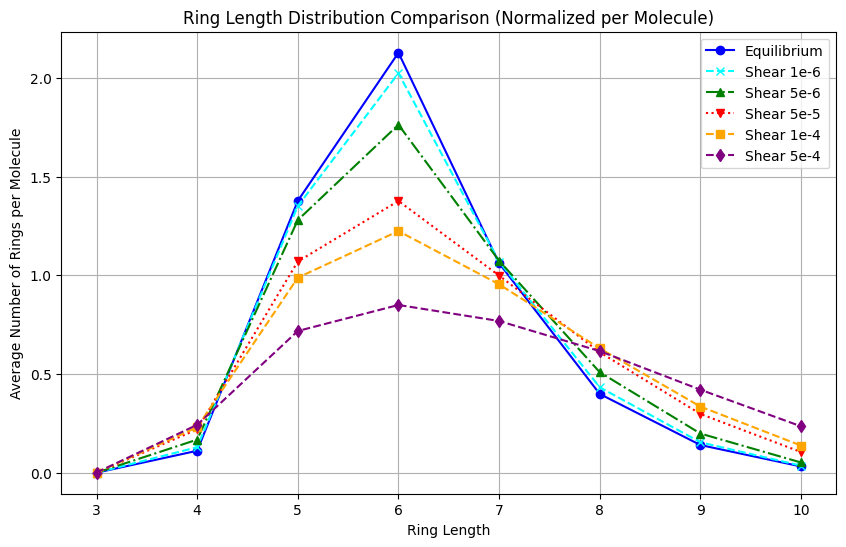

In [16]:
# 补充distribution of particle-ring lengths normalized to represent the average number of rings of a given length per molecule.
ring_length_counts1 = result1['ring_len'].value_counts().sort_index()
ring_length_counts2 = result2['ring_len'].value_counts().sort_index()
ring_length_counts3 = result3['ring_len'].value_counts().sort_index()
ring_length_counts4 = result4['ring_len'].value_counts().sort_index()
ring_length_counts5 = result5['ring_len'].value_counts().sort_index()
ring_length_counts6 = result6['ring_len'].value_counts().sort_index()
# 做上述要求的归一化操作（先除以抽样帧数并非总帧数，再除以分子数）
ring_length_counts1 = ring_length_counts1 / len(result1["frame"].unique()) / len(single_analyzer.O_atoms) 
ring_length_counts2 = ring_length_counts2 / len(result2["frame"].unique()) / len(single_analyzer.O_atoms)
ring_length_counts3 = ring_length_counts3 / len(result3["frame"].unique()) / len(single_analyzer.O_atoms)
ring_length_counts4 = ring_length_counts4 / len(result4["frame"].unique()) / len(single_analyzer.O_atoms)
ring_length_counts5 = ring_length_counts5 / len(result5["frame"].unique()) / len(single_analyzer.O_atoms)
ring_length_counts6 = ring_length_counts6 / len(result6["frame"].unique()) / len(single_analyzer.O_atoms)
plt.figure(figsize=(10, 6))
plt.plot(ring_length_counts1.index, ring_length_counts1.values, marker='o', linestyle='-', label='Equilibrium', color='blue')
plt.plot(ring_length_counts4.index, ring_length_counts4.values, marker='x', linestyle='--', label='Shear 1e-6', color='cyan')
plt.plot(ring_length_counts5.index, ring_length_counts5.values, marker='^', linestyle='-.', label='Shear 5e-6', color='green')
plt.plot(ring_length_counts6.index, ring_length_counts6.values, marker='v', linestyle=':', label='Shear 5e-5', color='red')
plt.plot(ring_length_counts2.index, ring_length_counts2.values, marker='s', linestyle='--', label='Shear 1e-4', color='orange')
plt.plot(ring_length_counts3.index, ring_length_counts3.values, marker='d', linestyle='--', label='Shear 5e-4', color='purple')
plt.title('Ring Length Distribution Comparison (Normalized per Molecule)')
plt.xlabel('Ring Length')
plt.ylabel('Average Number of Rings per Molecule')
plt.xticks(ring_length_counts1.index)
plt.grid()
plt.legend()
plt.show()

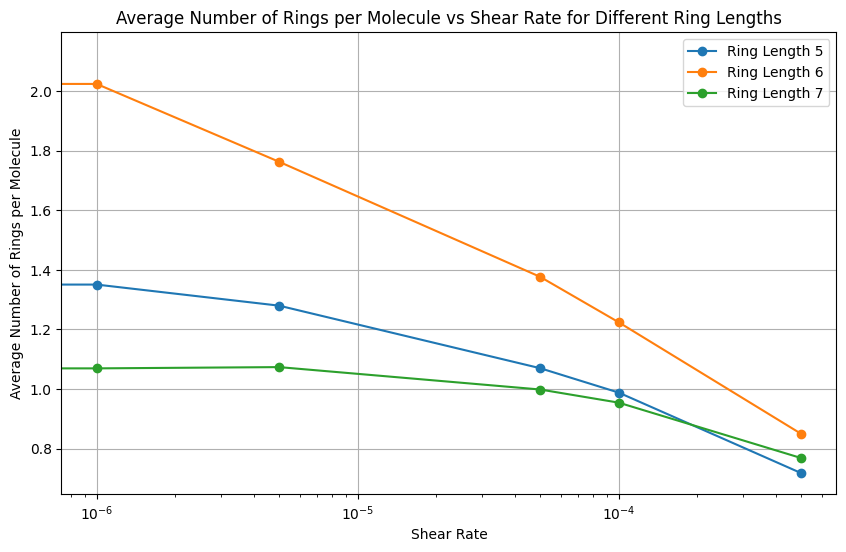

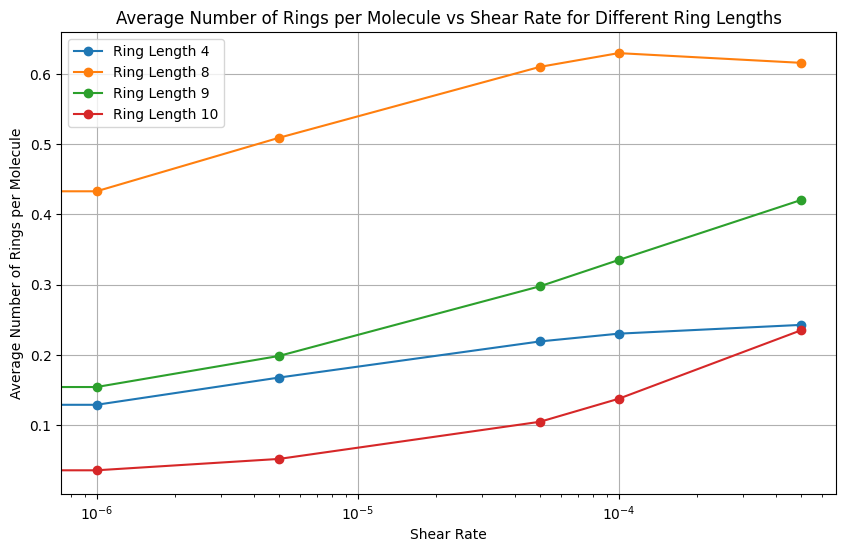

In [20]:
# 绘制平均分子环数在不同环长度下随剪切速率变化的趋势图
shear_rates = ['Equilibrium', "1e-6", '5e-6', '5e-5', '1e-4', '5e-4']
ring_length_data = {
    'Equilibrium': ring_length_counts1,
    "1e-6": ring_length_counts4,
    '5e-6': ring_length_counts5,
    '5e-5': ring_length_counts6,
    '1e-4': ring_length_counts2,
    '5e-4': ring_length_counts3
}
rates_numeric = [0, 1e-6, 5e-6, 5e-5, 1e-4, 5e-4]
# 用直线拟合求出绘制得到的counts-rates_numeric的斜率
plt.figure(figsize=(10, 6))
for ring_len in range(5, 8):
    counts = []
    for rate in shear_rates:
        counts.append(ring_length_data[rate].get(ring_len, 0))
    plt.plot(rates_numeric, counts, marker='o', label=f'Ring Length {ring_len}')
plt.xlabel('Shear Rate')
plt.xscale('log')
plt.ylabel('Average Number of Rings per Molecule')
plt.title('Average Number of Rings per Molecule vs Shear Rate for Different Ring Lengths')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 6))
for ring_len in [4, 8, 9, 10]:
    counts = []
    for rate in shear_rates:
        counts.append(ring_length_data[rate].get(ring_len, 0))
    plt.plot(rates_numeric, counts, marker='o', label=f'Ring Length {ring_len}')
plt.xlabel('Shear Rate')
plt.xscale('log')
plt.ylabel('Average Number of Rings per Molecule')
plt.title('Average Number of Rings per Molecule vs Shear Rate for Different Ring Lengths')
plt.legend()
plt.grid(True)
plt.show()

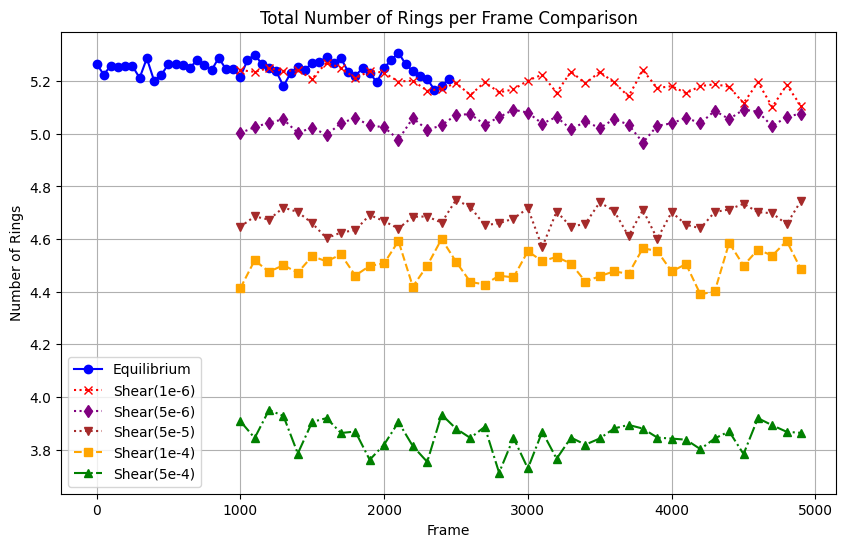

In [18]:
# 检查Number of rings totally per frame
rings_per_frame1 = result1.groupby('frame').size() / len(single_analyzer.O_atoms)
rings_per_frame2 = result2.groupby('frame').size() / len(single_analyzer.O_atoms)
rings_per_frame3 = result3.groupby('frame').size() / len(single_analyzer.O_atoms)
rings_per_frame4 = result4.groupby('frame').size() / len(single_analyzer.O_atoms)
rings_per_frame5 = result5.groupby('frame').size() / len(single_analyzer.O_atoms)
rings_per_frame6 = result6.groupby('frame').size() / len(single_analyzer.O_atoms)
plt.figure(figsize=(10, 6))
plt.plot(rings_per_frame1.index, rings_per_frame1.values, marker='o', linestyle='-', label='Equilibrium', color='blue')
plt.plot(rings_per_frame4.index, rings_per_frame4.values, marker='x', linestyle=':', label='Shear(1e-6)', color='red')
plt.plot(rings_per_frame5.index, rings_per_frame5.values, marker='d', linestyle=':', label='Shear(5e-6)', color='purple')
plt.plot(rings_per_frame6.index, rings_per_frame6.values, marker='v', linestyle=':', label='Shear(5e-5)', color='brown')
plt.plot(rings_per_frame2.index, rings_per_frame2.values, marker='s', linestyle='--', label='Shear(1e-4)', color='orange')
plt.plot(rings_per_frame3.index, rings_per_frame3.values, marker='^', linestyle='-.', label='Shear(5e-4)', color='green')
plt.title('Total Number of Rings per Frame Comparison')
plt.xlabel('Frame')
plt.ylabel('Number of Rings')
plt.grid()
plt.legend()
plt.show()

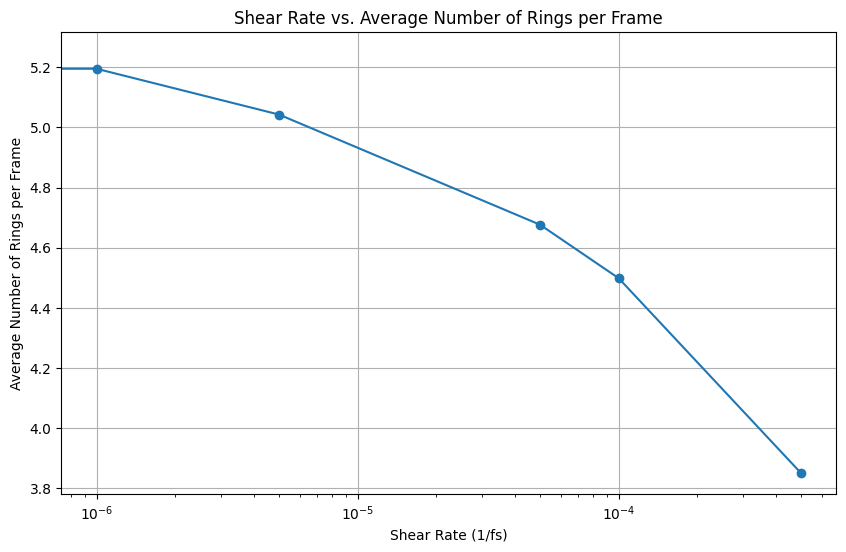

In [19]:
# 绘制剪切率与ring数量的关系图
shear_rates = [0, 
               1e-6, 
               5e-6, 5e-5, 1e-4, 5e-4]
average_rings = [
    rings_per_frame1.mean(),
    rings_per_frame4.mean(),
    rings_per_frame5.mean(),
    rings_per_frame6.mean(),
    rings_per_frame2.mean(),
    rings_per_frame3.mean()
]
plt.figure(figsize=(10, 6))
plt.plot(shear_rates, average_rings, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Shear Rate (1/fs)')
plt.ylabel('Average Number of Rings per Frame')
plt.title('Shear Rate vs. Average Number of Rings per Frame')
plt.grid()
plt.show()

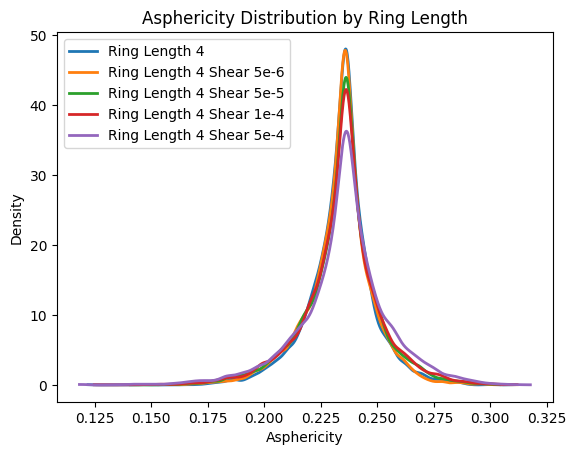

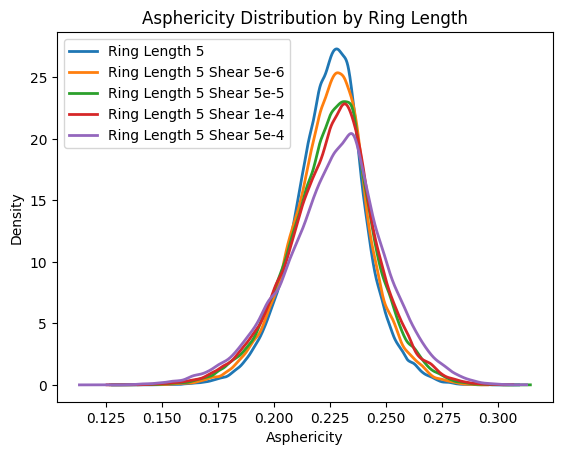

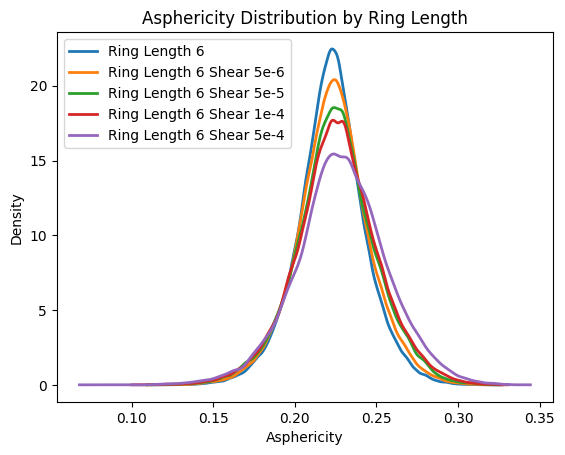

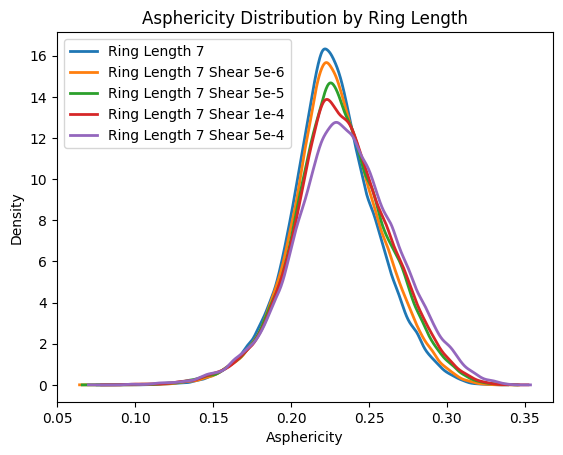

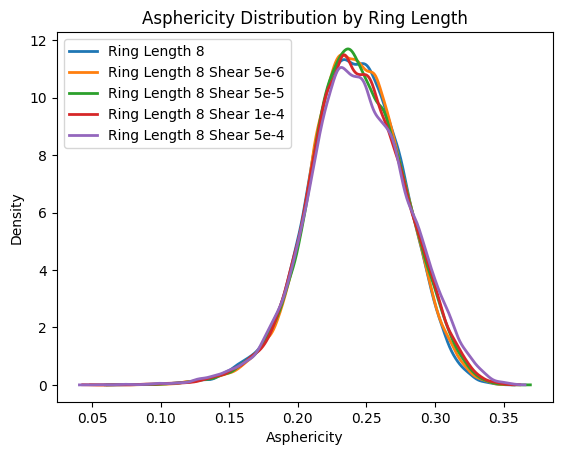

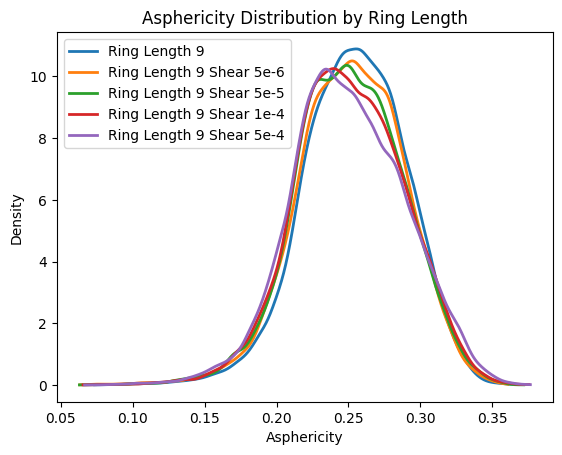

In [ ]:
ring_lengths = sorted(result1['ring_len'].unique())
# 控制每个result的线型和颜色
ring_lengths = [4, 
                5, 6, 7, 8, 9
                ]
colors = ['blue', 
          'green', 'red', 'purple', 'orange', 'brown'
          ]
for ring_len, color in zip(ring_lengths, colors):
    
    # if ring_len != 4 and ring_len != 5 and ring_len != 6 and ring_len != 7 and ring_len != 8:
    #     continue
    def plot_kde(data, ring_len, linestyle, label, color):
        subset = data[data['ring_len'] == ring_len]
        kde = gaussian_kde(subset['asphericity'])
        x_min = subset['asphericity'].min()
        x_max = subset['asphericity'].max()
        x = np.linspace(x_min, x_max, 1000)
        plt.plot(x, kde(x), label=label, linewidth=2)
    plot_kde(result1, ring_len, '-', f'Ring Length {ring_len}', color)
    plot_kde(result5, ring_len, '--', f'Ring Length {ring_len} Shear 5e-6', color)
    plot_kde(result6, ring_len, '--', f'Ring Length {ring_len} Shear 5e-5', color)
    plot_kde(result2, ring_len, '--', f'Ring Length {ring_len} Shear 1e-4', color)
    plot_kde(result3, ring_len, '--', f'Ring Length {ring_len} Shear 5e-4', color)
    plt.xlabel('Asphericity')
    plt.ylabel('Density')
    plt.title('Asphericity Distribution by Ring Length')
    plt.legend()
    plt.show()

In [2]:
from hb_analysis import StructureAnalyzer

In [10]:
file_path = "/home/debian/water/TIP4P/Ice/225/dump_225_test.lammpstrj"
# u = mda.Universe(file_path, format="LAMMPSDUMP")
analyzer = StructureAnalyzer(file_path)

In [11]:
results = analyzer.analyze_frame(0)

57263
2.754992 6.9730234


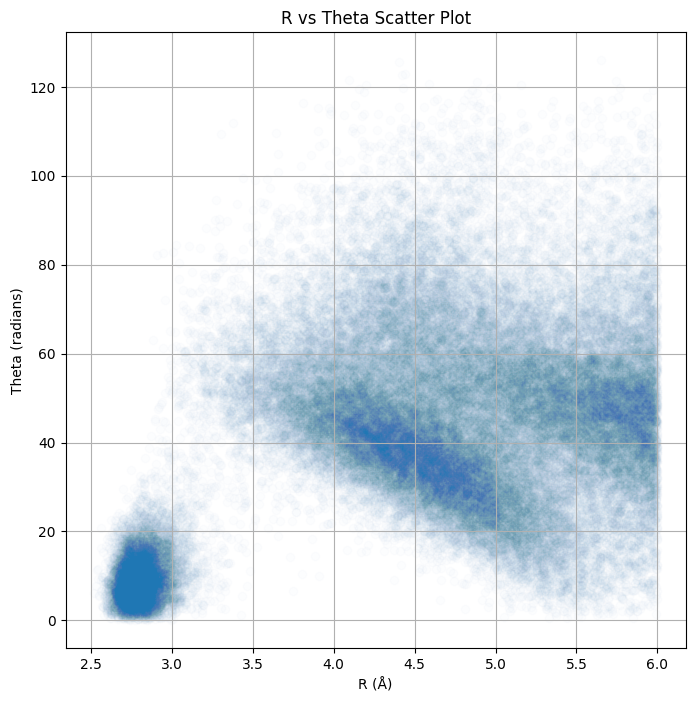

In [12]:
print(len(results.values()))
# 获取results.values()中的第一项元素
first_value, second_value = next(iter(results.values()))
print(first_value, second_value)
# 画出所有first_value, second_value的散点图
import matplotlib.pyplot as plt
rs = []
thetas = []
for r, theta in results.values():
    rs.append(r)
    thetas.append(theta)
plt.figure(figsize=(8, 8))
plt.scatter(rs, thetas, alpha=0.01)
plt.xlabel('R (Å)')
plt.ylabel('Theta (radians)')
plt.title('R vs Theta Scatter Plot')
plt.grid()
plt.show()

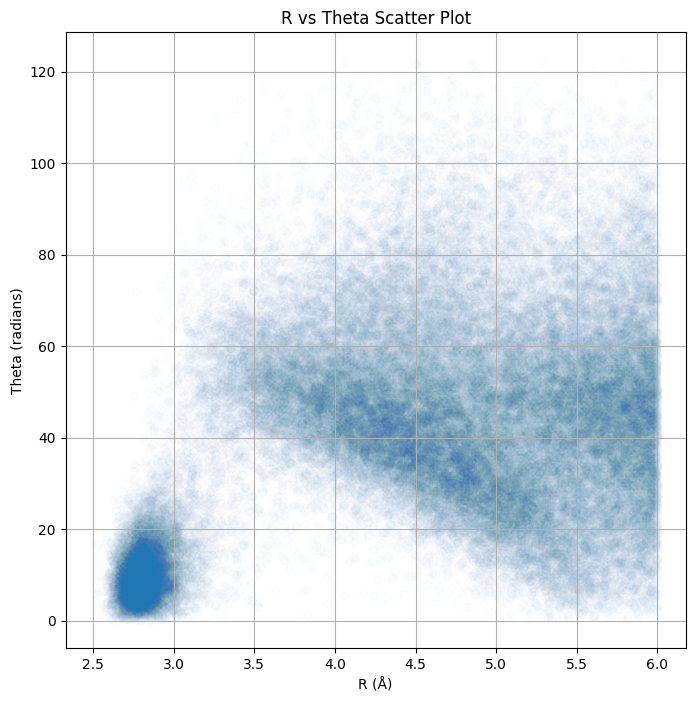

In [9]:
file_path = "/home/debian/water/TIP4P/Ice/225/shear/traj_1e-4_225.0.lammpstrj"
# u = mda.Universe(file_path, format="LAMMPSDUMP")
new_analyzer = StructureAnalyzer(file_path)
new_results = new_analyzer.analyze_frame(2000)
# 画出所有first_value, second_value的散点图
import matplotlib.pyplot as plt
rs = []
thetas = []
for r, theta in new_results.values():
    rs.append(r)
    thetas.append(theta)
plt.figure(figsize=(8, 8))
plt.scatter(rs, thetas, alpha=0.01)
plt.xlabel('R (Å)')
plt.ylabel('Theta (radians)')
plt.title('R vs Theta Scatter Plot')
plt.grid()
plt.show()

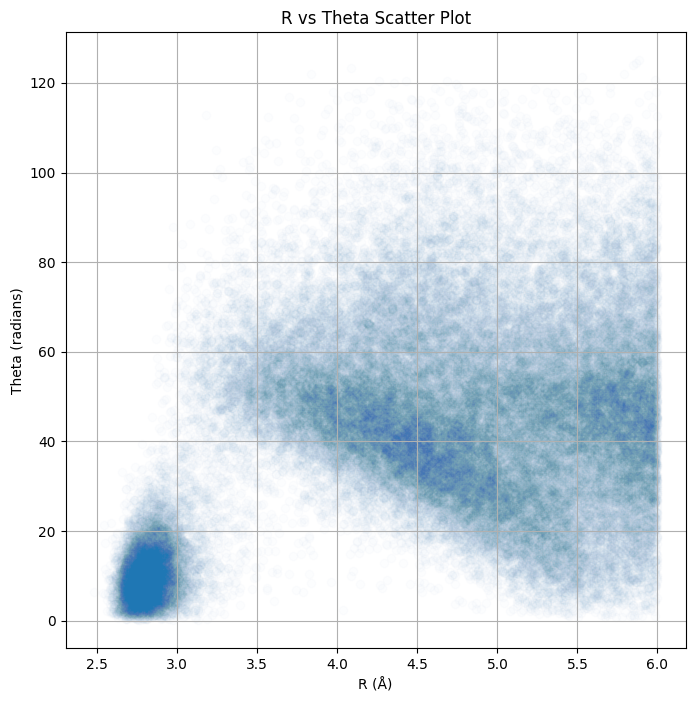

In [8]:
file_path = "/home/debian/water/TIP4P/Ice/225/shear/traj_5e-5_225.0.lammpstrj"
# u = mda.Universe(file_path, format="LAMMPSDUMP")
new_analyzer = StructureAnalyzer(file_path)
new_results = new_analyzer.analyze_frame(2000)
# 画出所有first_value, second_value的散点图
import matplotlib.pyplot as plt
rs = []
thetas = []
for r, theta in new_results.values():
    rs.append(r)
    thetas.append(theta)
plt.figure(figsize=(8, 8))
plt.scatter(rs, thetas, alpha=0.01)
plt.xlabel('R (Å)')
plt.ylabel('Theta (radians)')
plt.title('R vs Theta Scatter Plot')
plt.grid()
plt.show()

In [2]:
# 取一个剪切速率下某一帧的八环形状分布图
print(result2.head())

   frame  center  ring_len                                         ring_nodes  \
0   1000       3         4                          (3, 11856, 7677, 7563, 3)   
1   1000       3         6             (3, 11856, 2280, 1989, 11400, 6660, 3)   
2   1000       3         7         (3, 11856, 2280, 2526, 5991, 315, 8295, 3)   
3   1000       3         8  (3, 7563, 7677, 11856, 2280, 1989, 11400, 6660...   
4   1000       3         8   (3, 7563, 7728, 11427, 561, 6246, 4659, 8295, 3)   

            pair  elongation  asphericity  
0  (11856, 7563)    0.067001     0.200927  
1  (11856, 6660)    0.243812     0.239119  
2  (11856, 8295)    0.172376     0.222372  
3   (7563, 6660)    0.357804     0.264517  
4   (7563, 8295)    0.465742     0.287592  


In [3]:
results2_ring8 = result2[result2["ring_len"] == 8]
print(results2_ring8.head())

    frame  center  ring_len  \
3    1000       3         8   
4    1000       3         8   
10   1000    8295         8   
14   1000   11856         8   
24   1000    2784         8   

                                           ring_nodes          pair  \
3   (3, 7563, 7677, 11856, 2280, 1989, 11400, 6660...  (7563, 6660)   
4    (3, 7563, 7728, 11427, 561, 6246, 4659, 8295, 3)  (7563, 8295)   
10  (8295, 3, 7563, 60, 5685, 3093, 8721, 11262, 8...    (3, 11262)   
14  (11856, 2280, 1989, 11400, 6660, 3, 7563, 7677...  (2280, 7677)   
24  (2784, 4041, 585, 3483, 9702, 8139, 3546, 915,...   (4041, 915)   

    elongation  asphericity  
3     0.357804     0.264517  
4     0.465742     0.287592  
10    0.120841     0.211295  
14    0.357804     0.264517  
24    0.554366     0.308582  


In [4]:
single_analyzer.coords.shape
ring_nodes = [i // 3 for i in results2_ring8['ring_nodes'].iloc[0]] # 转换为原子索引
frame_idx = results2_ring8['frame'].iloc[0]
coords = single_analyzer.coords[frame_idx, ring_nodes]
box = single_analyzer.boxes[frame_idx]
# 已知该八环的原子坐标coords，得到该八环的体积大小
vectors = coords[1:] - coords[:-1]
from MDAnalysis.lib.distances import minimize_vectors
vectors = minimize_vectors(vectors, box)
print(vectors)

[[ 2.30700684 -1.21189976 -0.9612999 ]
 [-1.58401489 -2.30609989  0.40019989]
 [-0.73596191  1.16240025  2.29780197]
 [-2.38601685  0.47739983  1.60929871]
 [ 0.66999817  2.8382597   0.33170319]
 [-1.04399109  1.82994366 -1.65570068]
 [ 2.35998535 -0.10216331 -1.30320358]
 [ 0.41299438 -2.68784046 -0.71879959]]


In [9]:
print(single_analyzer.boxes[:5])

[[50.         50.         50.         90.         90.         90.        ]
 [50.         50.00999832 50.         90.         90.         88.85424042]
 [50.         50.03998566 50.         90.         90.         87.70938873]
 [50.         50.08992004 50.         90.         90.         86.5663681 ]
 [50.         50.15974426 50.         90.         90.         85.4260788 ]]


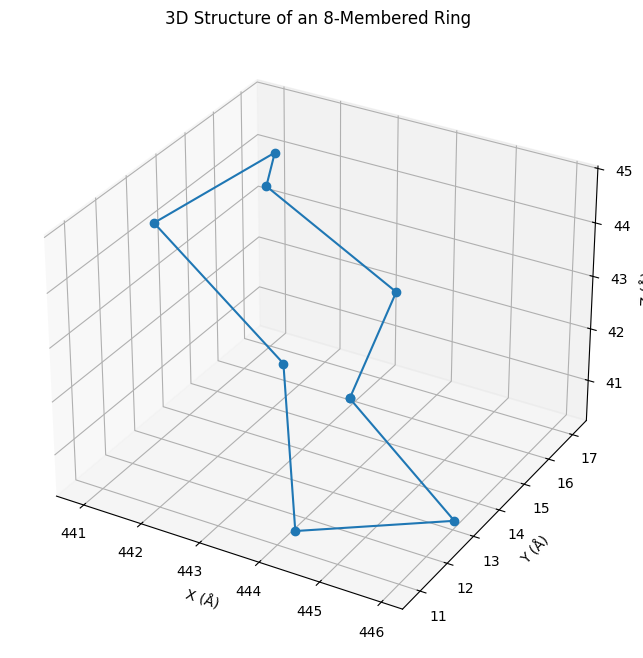

In [5]:
# 绘制三维八环结构
from mpl_toolkits.mplot3d import Axes3D
coords_adjusted = minimize_vectors(coords - coords.mean(axis=0), box) + coords.mean(axis=0)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(coords_adjusted[:, 0], coords_adjusted[:, 1], coords_adjusted[:, 2], marker='o')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('3D Structure of an 8-Membered Ring')
plt.show()

In [6]:
min_x = np.min(coords_adjusted[:, 0])
max_x = np.max(coords_adjusted[:, 0])
min_y = np.min(coords_adjusted[:, 1])
max_y = np.max(coords_adjusted[:, 1])
min_z = np.min(coords_adjusted[:, 2])
max_z = np.max(coords_adjusted[:, 2])
length_x = max_x - min_x
length_y = max_y - min_y
length_z = max_z - min_z
volume = length_x * length_y * length_z
print(f"min_x: {min_x:.2f}, max_x: {max_x:.2f}, length_x: {length_x:.2f} Å")
print(f"min_y: {min_y:.2f}, max_y: {max_y:.2f}, length_y: {length_y:.2f} Å")
print(f"min_z: {min_z:.2f}, max_z: {max_z:.2f}, length_z: {length_z:.2f} Å")
print(f"Estimated volume of the 8-membered ring: {volume:.2f} Å³")

min_x: 440.89, max_x: 445.97, length_x: 5.08 Å
min_y: 10.82, max_y: 17.13, length_y: 6.31 Å
min_z: 40.31, max_z: 44.95, length_z: 4.64 Å
Estimated volume of the 8-membered ring: 148.65 Å³


In [10]:
# 同上，我们可以统计所有八环的x，y，z方向的长度分布情况
lengths_x = []
lengths_y = []
lengths_z = []
for idx, row in results2_ring8.iterrows():
    # 正确处理周期性边界条件
    ring_nodes = [i // 3 for i in row['ring_nodes']] # 转换为原子索引
    frame_idx = row['frame']
    coords = single_analyzer.coords[frame_idx, ring_nodes][:-1] # 去掉最后一个重复的节点
    box = single_analyzer.boxes[frame_idx]
    coords_adjusted = minimize_vectors(coords - coords.mean(axis=0), box) + coords.mean(axis=0)
    min_x = np.min(coords_adjusted[:, 0])
    max_x = np.max(coords_adjusted[:, 0])
    min_y = np.min(coords_adjusted[:, 1])
    max_y = np.max(coords_adjusted[:, 1])
    min_z = np.min(coords_adjusted[:, 2])
    max_z = np.max(coords_adjusted[:, 2])
    length_x = max_x - min_x
    length_y = max_y - min_y
    length_z = max_z - min_z
    if length_x > 45 or length_y > 45 or length_z > 45:
        print(f"Frame {frame_idx}, Ring nodes {ring_nodes} has abnormal lengths: x={length_x}, y={length_y}, z={length_z}")
        print(idx, row)
        break
    lengths_x.append(length_x)
    lengths_y.append(length_y)
    lengths_z.append(length_z)

Frame 1000, Ring nodes [np.int64(928), np.int64(1347), np.int64(195), np.int64(1161), np.int64(3234), np.int64(2713), np.int64(1182), np.int64(305), np.int64(928)] has abnormal lengths: x=7.710205078125057, y=49.28580284118652, z=4.734371185302734
24 frame                                                       1000
center                                                      2784
ring_len                                                       8
ring_nodes     (2784, 4041, 585, 3483, 9702, 8139, 3546, 915,...
pair                                                 (4041, 915)
elongation                                              0.554366
asphericity                                             0.308582
Name: 24, dtype: object


In [11]:
# 检查环（Frame:1000, Ring nodes [np.int64(928), np.int64(1347), np.int64(195), np.int64(1161), np.int64(3234), np.int64(2713), np.int64(1182), np.int64(305), np.int64(928)]）
coord_test = single_analyzer.coords[1000, [928//3, 1347//3, 195//3, 1161//3, 3234//3, 2713//3, 1182//3, 305//3]]
box_test = single_analyzer.boxes[1000]
print(coord_test)
print(box_test)

[[ 307.67498779   26.39801979   26.09988976]
 [ 587.36499023   32.6029892    26.93725967]
 [-146.6210022    -8.70389938   65.02389526]
 [ 113.4375        4.8383007    53.60309982]
 [1045.59008789   49.36039734    4.49950027]
 [ 458.7789917    28.09757042   34.82418823]
 [ 209.72399902    9.39750004   -5.68330002]
 [-183.29600525   -3.80380058   16.42721939]]
[50. 50. 50. 90. 90. 90.]


[[ 7.674988  26.39802   26.09989  ]
 [37.36499   32.60299   26.93726  ]
 [ 3.3789978 41.2961    15.023895 ]
 [13.4375     4.8383007  3.6031017]
 [-4.409914  49.360397   4.4995003]
 [ 8.778992  28.09757   34.82419  ]
 [ 9.723999   9.397499  44.316696 ]
 [16.703995  46.196198  16.42722  ]]


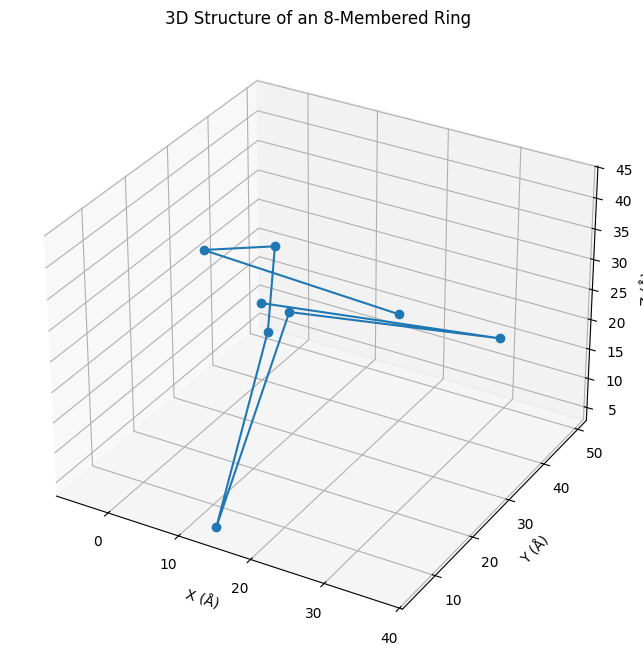

In [14]:
# 绘制三维八环结构
from mpl_toolkits.mplot3d import Axes3D
from MDAnalysis.lib.distances import apply_PBC
coord_test = apply_PBC(coord_test, box_test)
coords_adjusted_test = minimize_vectors(coord_test - coord_test.mean(axis=0), box_test) + coord_test.mean(axis=0)
print(coords_adjusted_test)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(coords_adjusted_test[:, 0], coords_adjusted_test[:, 1], coords_adjusted_test[:, 2], marker='o')
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
ax.set_title('3D Structure of an 8-Membered Ring')
plt.show()

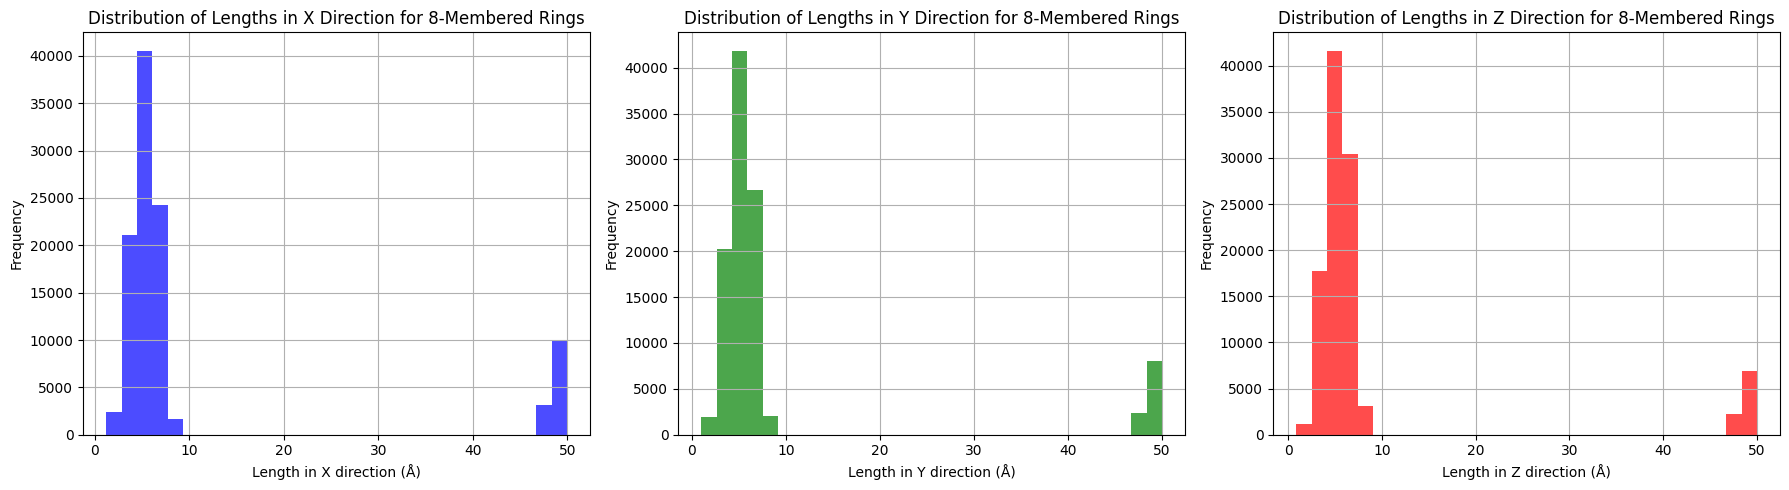

In [8]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.hist(lengths_x, bins=30, color='blue', alpha=0.7)
plt.xlabel('Length in X direction (Å)')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths in X Direction for 8-Membered Rings')
plt.grid()
plt.subplot(1, 3, 2)
plt.hist(lengths_y, bins=30, color='green', alpha=0.7)
plt.xlabel('Length in Y direction (Å)')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths in Y Direction for 8-Membered Rings')
plt.grid()
plt.subplot(1, 3, 3)
plt.hist(lengths_z, bins=30, color='red', alpha=0.7)
plt.xlabel('Length in Z direction (Å)')
plt.ylabel('Frequency')
plt.title('Distribution of Lengths in Z Direction for 8-Membered Rings')
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
import MDAnalysis as mda
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = "/home/debian/water/TIP4P/Ice/225/shear/traj_1e-4_225.0.lammpstrj"
u = mda.Universe(file_path, format="LAMMPSDUMP")
boxes = []
for ts in u.trajectory[:10]:
    print(ts)
    print(ts.dimensions)
    boxes.append(ts.dimensions.copy())
boxes = np.array(boxes)

/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:651: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/debian/myenv/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


< Timestep 0 with unit cell dimensions [50. 50. 50. 90. 90. 90.] >
[50. 50. 50. 90. 90. 90.]
< Timestep 1 with unit cell dimensions [50.      50.01    50.      90.      90.      88.85424] >
[50.      50.01    50.      90.      90.      88.85424]
< Timestep 2 with unit cell dimensions [50.       50.039986 50.       90.       90.       87.70939 ] >
[50.       50.039986 50.       90.       90.       87.70939 ]
< Timestep 3 with unit cell dimensions [50.      50.08992 50.      90.      90.      86.56637] >
[50.      50.08992 50.      90.      90.      86.56637]
< Timestep 4 with unit cell dimensions [50.       50.159744 50.       90.       90.       85.42608 ] >
[50.       50.159744 50.       90.       90.       85.42608 ]
< Timestep 5 with unit cell dimensions [50.       50.24938  50.       90.       90.       84.289406] >
[50.       50.24938  50.       90.       90.       84.289406]
< Timestep 6 with unit cell dimensions [50.       50.358715 50.       90.       90.       83.15723 ] >
[50

In [14]:
print(boxes)

[[50.       50.       50.       90.       90.       90.      ]
 [50.       50.01     50.       90.       90.       88.85424 ]
 [50.       50.039986 50.       90.       90.       87.70939 ]
 [50.       50.08992  50.       90.       90.       86.56637 ]
 [50.       50.159744 50.       90.       90.       85.42608 ]
 [50.       50.24938  50.       90.       90.       84.289406]
 [50.       50.358715 50.       90.       90.       83.15723 ]
 [50.       50.48762  50.       90.       90.       82.03039 ]
 [50.       50.635956 50.       90.       90.       80.90972 ]
 [50.       50.803543 50.       90.       90.       79.79603 ]]


In [9]:
print(np.array(boxes)[:,3]) # x方向盒子长度
if np.any(np.array(boxes)[:,3] != 90.0):
    print("存在x方向盒子长度不为90.0的情况")
print(np.array(boxes)[:,4]) # y方向盒子长度
if np.any(np.array(boxes)[:,4] != 90.0):
    print("存在y方向盒子长度不为90.0的情况")
print(np.array(boxes)[:,5]) # z方向盒子长度
if np.any(np.array(boxes)[:,5] != 90.0):
    print("存在z方向盒子长度不为90.0的情况")

[90. 90. 90. ... 90. 90. 90.]
[90. 90. 90. ... 90. 90. 90.]
[90. 90. 90. ... 90. 90. 90.]


# 检查平衡态和剪切态下的配位缺陷情况

In [1]:
from hb_network import HBondAnalyzer
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 平衡态检测
file_path = "/home/debian/water/TIP4P/Ice/225/rst/hbonds.h5"
equili_analyzer = HBondAnalyzer(file_path)
file_path = "/home/debian/water/TIP4P/Ice/225/shear/rst/1e-4/hbonds.h5"
shear_analyzer = HBondAnalyzer(file_path)

In [ ]:
# 根据hbonds_df 查询统计每个粒子的氢键配位情况
print(equili_analyzer.hbonds_df.head())


   frame  donor  hydrogen  acceptor  distance       angle
0      0      0         2       978  2.992654  161.168655
1      0      0         1     10095  2.803161  160.342972
2      0      3         5      7542  2.875823  153.439331
3      0      3         4     10026  2.997493  172.182632
4      0      6         8     10437  2.714434  166.850266


equili: tau_alpha = 44.27252 ps
  KWW fit: A=0.6226, tau=133.9865 ps, beta=0.5893


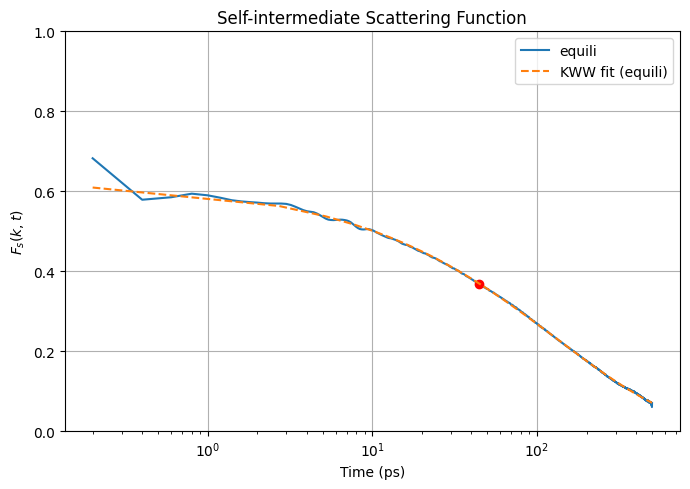

In [1]:
import matplotlib.pyplot as plt
from isf_visualize import plot_isf
plt.figure(figsize=(7,5))
plot_isf("/home/debian/water/TIP4P/Ice/225/shear/isf_results.h5","equili")
plt.xlabel("Time (ps)")
plt.xscale("log")
plt.ylabel(r"$F_s(k,t)$")
plt.title("Self-intermediate Scattering Function")
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MSD Analysis for equili:
Fitted Diffusion Coefficient D = 2.79692e-03 Å²/ps, R² = 0.81832


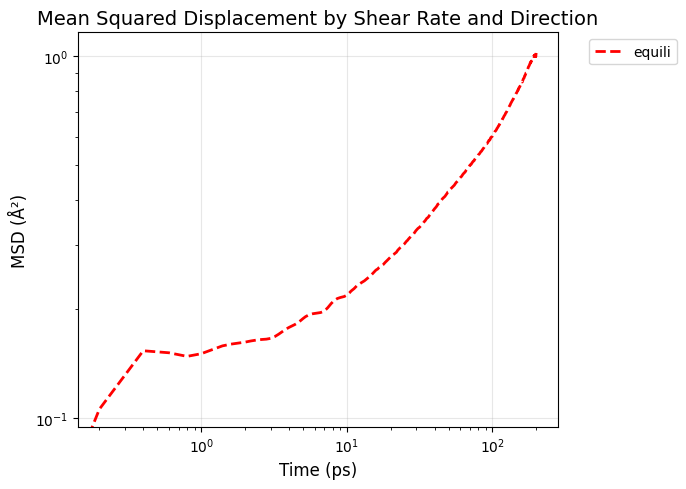

In [4]:
from msd_visualize import plot_msd
plt.figure(figsize=(7,5))
plot_msd("/home/debian/water/TIP4P/Ice/225/shear/msd_results.h5","equili",color='red',linestyle='--', label='equili')
plt.xlabel("Time (ps)", fontsize=12)
plt.xscale("log")
plt.ylabel("MSD (Å²)", fontsize=12)
plt.yscale("log")
plt.title("Mean Squared Displacement by Shear Rate and Direction", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)  # 图例放在右侧
plt.grid(True, alpha=0.3)
plt.tight_layout()

Max χ4 = 10.68650 at τ_chi = 59.40000 ps


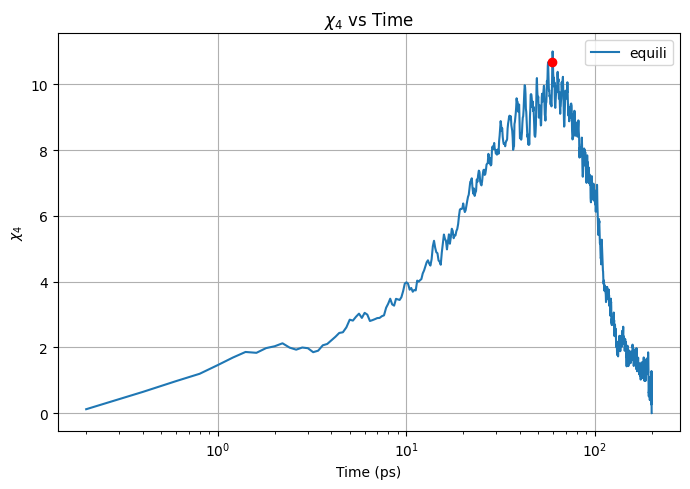

In [5]:
from chi_visualize import plot_chi
plt.figure(figsize=(7,5))
plot_chi("/home/debian/water/TIP4P/Ice/225/shear/rst/chi4_results.h5", "equili")
plt.xlabel("Time (ps)")
plt.ylabel(r"$\chi_4$")
plt.title(r"$\chi_4$ vs Time")
plt.xscale("log")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()